In [1]:
import pyarrow as pa
import pyarrow.parquet as pq
# import fiona
from math import radians, cos, sin, asin, sqrt 
import pandas as pd
import numpy as np
import os
from engarde.decorators import none_missing, unique_index, is_shape
import engarde.generic
import engarde.decorators as ed
from pyproj import Geod
# for plotting map Leaflet library
import folium
from folium import plugins
import scipy
from itertools import cycle
import math
from scipy.spatial import distance
import timeit
import time
import datetime
import sys
from IPython.display import display
import matplotlib.colors as colorscale
#for plotting barcharts and histograms and line chart 
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy import signal
import scipy.stats as stats
import pylab as pl
import plotly.plotly as py
import plotly.graph_objs as go
import geojson as jj
from geojson import Feature, Point, FeatureCollection
import colorsys
import random
from pykalman import KalmanFilter
from scipy import stats 
plt.rcParams['figure.figsize'] = 13,8
import matplotlib.ticker as mtick
import warnings
warnings.filterwarnings('ignore')
# warnings.filterwarnings(action='once')
import plotly as pyPlot
pyPlot.tools.set_credentials_file(username='ladhar.ravishankar', api_key='uzbvUCS23VktDu0VC3l0')
pyPlot.tools.set_config_file(world_readable=True, sharing='public')
import json

# Zone 16 first month Data

In [2]:
#start_time = timeit.default_timer()
result_frame = pq.read_table('/bigdata0/rshankar/Zone16_2011/01/Broadcast.parquet').to_pandas()
result_frame = result_frame.sort_values(['MMSI', 'BaseDateTime'])

result_frame['CheckMMSI'] = (result_frame['MMSI'] != result_frame['MMSI'].shift(1))


#shifting the whole dataframe rows and calculating radians latitude
result_frame['latRad'] = np.where(result_frame['CheckMMSI'] != True , result_frame['lat'].shift(1).apply(radians), np.nan)
result_frame['lonRad'] = np.where(result_frame['CheckMMSI'] != True , result_frame['lon'].shift(1).apply(radians), np.nan)

#taking radinas for the small values
lat1 = result_frame['lat'].apply(radians)
lon1 = result_frame['lon'].apply(radians)

#taking difference for latitude and longitude
dlon = result_frame['lonRad'] - lon1 
dlat = result_frame['latRad'] - lat1

#calculating te distance
harvesineDist = (dlat/2).apply(sin)**2 + lat1.apply(cos) * result_frame['latRad'].apply(cos) * (dlon/2).apply(sin)**2
c = 2* np.arcsin(harvesineDist.apply(sqrt))
dist = 6367 * c

# c = 2 * (harvesineDist.apply(sqrt).apply(asin))
# dist =  * c

##--- Creating a new Data frame for Distance
list_dist =  pd.DataFrame({"Distance": dist})
#concatinating the Dataframe with the old Dataframe
result_frame = pd.concat([result_frame, list_dist], axis=1)
result_frame


#chaning the datetime from string to datetime stamp
result_frame['DateTime'] = pd.DatetimeIndex(result_frame['BaseDateTime'])
#df_Broadcast['DateTime']
#shfting the date on bool value and taking out the difference of two dates
result_frame['DateTime2'] = np.where(result_frame['CheckMMSI'] != True , result_frame['DateTime'].shift(1), result_frame['DateTime'])
result_frame['time_diff'] = (result_frame['DateTime'] - result_frame['DateTime2']) 
#calculating the total hours from baseDateTime
time = pd.DatetimeIndex(result_frame['time_diff'])
result_frame['totalHours'] = time.hour + (time.minute/60) + (time.second/3600)
result_frame= result_frame.reset_index()
#df_Broadcast


del result_frame['latRad']
del result_frame['lonRad']
del result_frame['DateTime2']
#del result_frame['time_diff']
del result_frame['CheckMMSI']

result_frame['Speed'] = result_frame['Distance'] / result_frame['totalHours']
result_frame = result_frame.replace([np.inf, -np.inf], np.nan)
result_frame= result_frame.replace([np.inf, -np.inf], np.nan).dropna(subset=["Speed"], how="all")


#print (timeit.default_timer() - start_time)

In [3]:
df = result_frame

In [4]:
df1 = df.set_index(pd.DatetimeIndex(df.DateTime))
variable1 = df1.groupby(['VoyageID']).rolling("5T").Speed.mean().reset_index(name= "rolling_mean").rename(columns={"VoyageID": "VoyageID2", "DateTime": "DT2"})
df = df.sort_values(['VoyageID', 'DateTime'], ascending=True).reset_index()
df = pd.concat([df, variable1], axis=1)

In [5]:
df_test = df

In [6]:
statinfo = os.stat('/bigdata0/rshankar/Zone16_2011/01/Broadcast.parquet')
statinfo

os.stat_result(st_mode=33188, st_ino=2802196, st_dev=47, st_nlink=1, st_uid=65534, st_gid=4294967294, st_size=473408588, st_atime=1556428006, st_mtime=1547407543, st_ctime=1547407543)

# Threshold Technique

In [7]:
df_test['Stopped']= df_test.groupby('VoyageID').apply(lambda x: x.rolling_mean.isnull()).values | df_test.groupby('VoyageID').apply(lambda x: x.rolling_mean >= 0.5).values
# df_test['Stopped_Count']= df_test.groupby('VoyageID').apply(lambda x: x.Stopped.mask(x.Stopped.groupby((x.Stopped).cumsum().where(~x.Stopped)).transform('count') < 10, ~x.Stopped)).values
df_test['subVoyageIDs']= (df_test.groupby('VoyageID').apply(lambda x:x.Stopped.shift(1)) != df_test.groupby('VoyageID').apply(lambda x:x.Stopped) | (df_test.groupby('VoyageID').apply(lambda x: x.rolling_mean <= 0.5).values)).astype(int).cumsum().values
print('Unique subVoyageIDs:', len(df_test.subVoyageIDs.unique()))
df_testResult= df_test[df_test['Stopped'] == True]

Unique subVoyageIDs: 10951876


In [8]:
df_threshold = df_test.set_index(pd.DatetimeIndex(result_frame.DateTime))

In [9]:
dataPoints = df_testResult.set_index(pd.DatetimeIndex(df_testResult.DateTime))
dataPoints= dataPoints.rename(columns={"index": "indexCol"})

In [10]:
df_CenteredWin =  dataPoints

In [11]:
datapoints= df_CenteredWin.groupby('subVoyageIDs').agg({'Speed':'count'}).reset_index().rename(columns ={'Speed':'totalPoints'})
datapoints = datapoints[datapoints.totalPoints < 10]

In [12]:
df_CenteredWin = df_CenteredWin[~(df_CenteredWin.subVoyageIDs.isin(datapoints.subVoyageIDs.unique()))]
# df_CenteredWin.groupby(['VoyageID','subVoyageIDs']).agg({'VoyageID':'count'})
# # ['subVoyageIDs'].count()

In [13]:
grouped = df_CenteredWin.groupby(['VoyageID', 'subVoyageIDs'])
grouped_count = grouped['subVoyageIDs'].count().reset_index(name="count")
# grouped_count = grouped_count[grouped_count['count'] > 1]
resultframe_Data1 = grouped_count.VoyageID.value_counts().nlargest(12141).reset_index(name = 'total_SubVoyages').rename(columns={"index": "VoyageID"})
resultframe_Data1

,VoyageID,total_SubVoyages
0,269,1051
1,218,805
2,140,786
3,282,764
4,131,756
5,55,744
6,226,701
7,179,679
8,183,665
9,232,559


Mean is: 12.576129972922308
Median is: 2.0


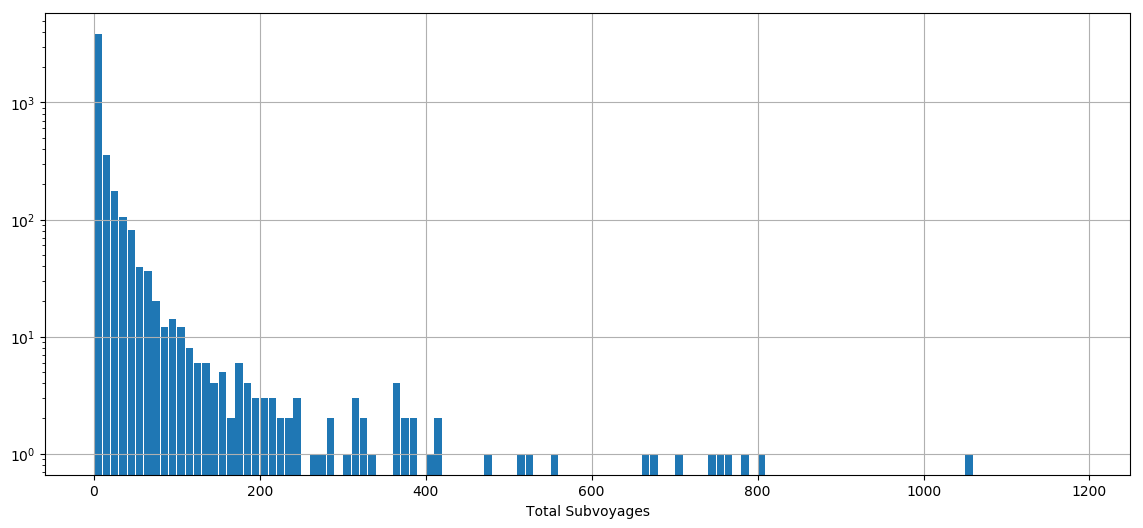

In [14]:
#https://community.modeanalytics.com/python/tutorial/python-histograms-boxplots-and-distributions/

bin_values = np.arange(start=0, stop=1200, step=10)
#print(bin_values)
print("Mean is:", resultframe_Data1.total_SubVoyages.mean())
print("Median is:", resultframe_Data1.total_SubVoyages.median())
resultframe_Data1['total_SubVoyages']
resultframe_Data1['total_SubVoyages'].hist(bins=bin_values, rwidth=0.9 ,figsize=[14,6])
plt.xlabel('Total Subvoyages');
plt.yscale('log',basey=10) 
#plt.hist(resultframe1['total_SubVoyages'], bins=(bin_values))
plt.show()

In [15]:
df_test['Stopped']= df_test.groupby('VoyageID').apply(lambda x: x.rolling_mean.isnull()).values | df_test.groupby('VoyageID').apply(lambda x: x.rolling_mean >= 0.4).values
# df_test['Stopped_Count']= df_test.groupby('VoyageID').apply(lambda x: x.Stopped.mask(x.Stopped.groupby((x.Stopped).cumsum().where(~x.Stopped)).transform('count') < 10, ~x.Stopped)).values
df_test['subVoyageIDs']= (df_test.groupby('VoyageID').apply(lambda x:x.Stopped.shift(1)) != df_test.groupby('VoyageID').apply(lambda x:x.Stopped) | (df_test.groupby('VoyageID').apply(lambda x: x.rolling_mean <= 0.4).values)).astype(int).cumsum().values
print('Unique subVoyageIDs:', len(df_test.subVoyageIDs.unique()))
df_testResult= df_test[df_test['Stopped'] == True]

Unique subVoyageIDs: 10707805


In [16]:
df_threshold = df_test.set_index(pd.DatetimeIndex(result_frame.DateTime))

In [17]:
dataPoints = df_testResult.set_index(pd.DatetimeIndex(df_testResult.DateTime))
dataPoints= dataPoints.rename(columns={"index": "indexCol"})

In [18]:
df_CenteredWin =  dataPoints

In [19]:
datapoints= df_CenteredWin.groupby('subVoyageIDs').agg({'Speed':'count'}).reset_index().rename(columns ={'Speed':'totalPoints'})
datapoints = datapoints[datapoints.totalPoints < 10]

In [20]:
df_CenteredWin = df_CenteredWin[~(df_CenteredWin.subVoyageIDs.isin(datapoints.subVoyageIDs.unique()))]
# df_CenteredWin.groupby(['VoyageID','subVoyageIDs']).agg({'VoyageID':'count'})
# # ['subVoyageIDs'].count()

In [21]:
grouped = df_CenteredWin.groupby(['VoyageID', 'subVoyageIDs'])
grouped_count = grouped['subVoyageIDs'].count().reset_index(name="count")
# grouped_count = grouped_count[grouped_count['count'] > 1]
resultframe_Data1 = grouped_count.VoyageID.value_counts().nlargest(12141).reset_index(name = 'total_SubVoyages').rename(columns={"index": "VoyageID"})
resultframe_Data1

,VoyageID,total_SubVoyages
0,269,1200
1,218,798
2,140,786
3,282,770
4,55,758
5,131,743
6,226,727
7,179,695
8,183,655
9,232,571


Mean is: 13.391891891891891
Median is: 2.0


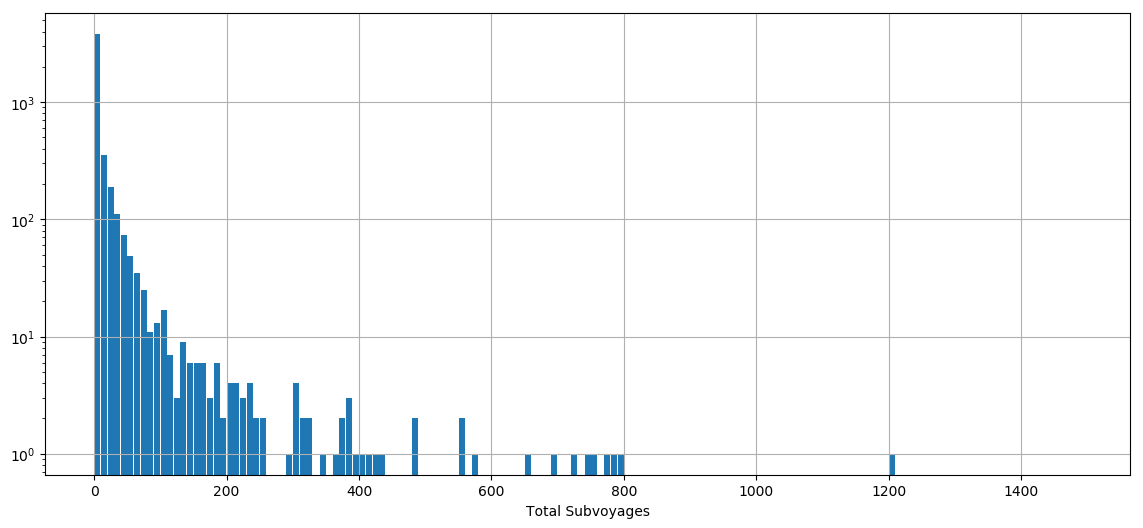

In [22]:
#https://community.modeanalytics.com/python/tutorial/python-histograms-boxplots-and-distributions/

bin_values = np.arange(start=0, stop=1500, step=10)
#print(bin_values)
print("Mean is:", resultframe_Data1.total_SubVoyages.mean())
print("Median is:", resultframe_Data1.total_SubVoyages.median())
resultframe_Data1['total_SubVoyages']
resultframe_Data1['total_SubVoyages'].hist(bins=bin_values, rwidth=0.9 ,figsize=[14,6])
plt.xlabel('Total Subvoyages');
plt.yscale('log',basey=10) 
#plt.hist(resultframe1['total_SubVoyages'], bins=(bin_values))
plt.show()

In [23]:
df_test['Stopped']= df_test.groupby('VoyageID').apply(lambda x: x.rolling_mean.isnull()).values | df_test.groupby('VoyageID').apply(lambda x: x.rolling_mean >= 0.7).values
# df_test['Stopped_Count']= df_test.groupby('VoyageID').apply(lambda x: x.Stopped.mask(x.Stopped.groupby((x.Stopped).cumsum().where(~x.Stopped)).transform('count') < 10, ~x.Stopped)).values
df_test['subVoyageIDs']= (df_test.groupby('VoyageID').apply(lambda x:x.Stopped.shift(1)) != df_test.groupby('VoyageID').apply(lambda x:x.Stopped) | (df_test.groupby('VoyageID').apply(lambda x: x.rolling_mean <= 0.7).values)).astype(int).cumsum().values
print('Unique subVoyageIDs:', len(df_test.subVoyageIDs.unique()))
df_testResult= df_test[df_test['Stopped'] == True]

Unique subVoyageIDs: 11191109


In [24]:
df_threshold = df_test.set_index(pd.DatetimeIndex(result_frame.DateTime))

In [25]:
dataPoints = df_testResult.set_index(pd.DatetimeIndex(df_testResult.DateTime))
dataPoints= dataPoints.rename(columns={"index": "indexCol"})

In [26]:
df_CenteredWin =  dataPoints

In [27]:
datapoints= df_CenteredWin.groupby('subVoyageIDs').agg({'Speed':'count'}).reset_index().rename(columns ={'Speed':'totalPoints'})
datapoints = datapoints[datapoints.totalPoints < 10]

In [28]:
df_CenteredWin = df_CenteredWin[~(df_CenteredWin.subVoyageIDs.isin(datapoints.subVoyageIDs.unique()))]
# df_CenteredWin.groupby(['VoyageID','subVoyageIDs']).agg({'VoyageID':'count'})
# # ['subVoyageIDs'].count()

In [29]:
grouped = df_CenteredWin.groupby(['VoyageID', 'subVoyageIDs'])
grouped_count = grouped['subVoyageIDs'].count().reset_index(name="count")
# grouped_count = grouped_count[grouped_count['count'] > 1]
resultframe_Data1 = grouped_count.VoyageID.value_counts().nlargest(12141).reset_index(name = 'total_SubVoyages').rename(columns={"index": "VoyageID"})
resultframe_Data1

,VoyageID,total_SubVoyages
0,218,801
1,140,777
2,269,768
3,282,740
4,131,737
5,55,712
6,226,675
7,179,636
8,183,635
9,57,538


Mean is: 11.960935867975767
Median is: 2.0


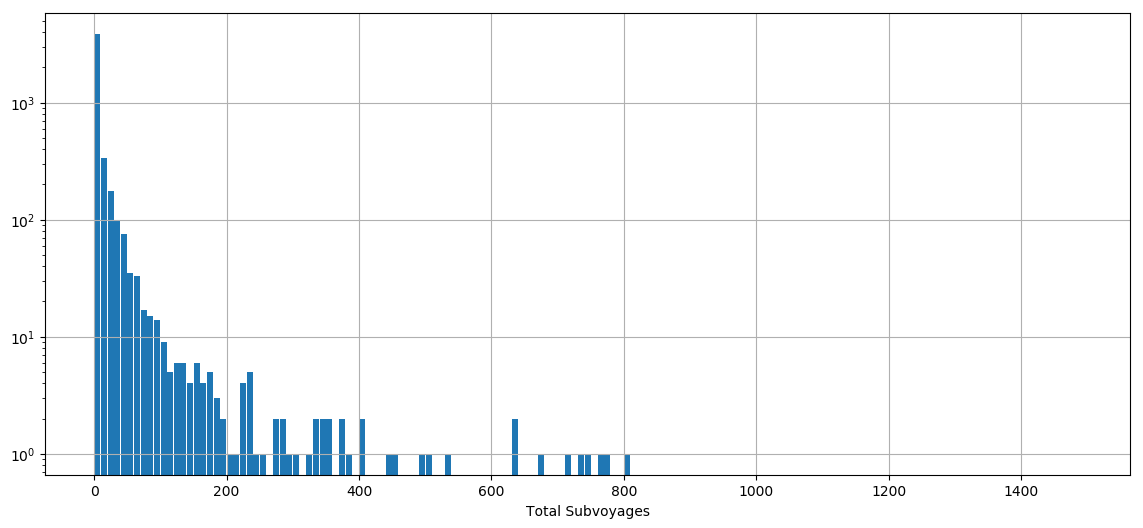

In [30]:
#https://community.modeanalytics.com/python/tutorial/python-histograms-boxplots-and-distributions/

bin_values = np.arange(start=0, stop=1500, step=10)
#print(bin_values)
print("Mean is:", resultframe_Data1.total_SubVoyages.mean())
print("Median is:", resultframe_Data1.total_SubVoyages.median())
resultframe_Data1['total_SubVoyages']
resultframe_Data1['total_SubVoyages'].hist(bins=bin_values, rwidth=0.9 ,figsize=[14,6])
plt.xlabel('Total Subvoyages');
plt.yscale('log',basey=10) 
#plt.hist(resultframe1['total_SubVoyages'], bins=(bin_values))
plt.show()

In [31]:
df_test['Stopped']= df_test.groupby('VoyageID').apply(lambda x: x.rolling_mean.isnull()).values | df_test.groupby('VoyageID').apply(lambda x: x.rolling_mean >= 1.0).values
# df_test['Stopped_Count']= df_test.groupby('VoyageID').apply(lambda x: x.Stopped.mask(x.Stopped.groupby((x.Stopped).cumsum().where(~x.Stopped)).transform('count') < 10, ~x.Stopped)).values
df_test['subVoyageIDs']= (df_test.groupby('VoyageID').apply(lambda x:x.Stopped.shift(1)) != df_test.groupby('VoyageID').apply(lambda x:x.Stopped) | (df_test.groupby('VoyageID').apply(lambda x: x.rolling_mean <= 1.0).values)).astype(int).cumsum().values
print('Unique subVoyageIDs:', len(df_test.subVoyageIDs.unique()))
df_testResult= df_test[df_test['Stopped'] == True]

Unique subVoyageIDs: 11385891


In [32]:
df_threshold = df_test.set_index(pd.DatetimeIndex(result_frame.DateTime))

In [33]:
dataPoints = df_testResult.set_index(pd.DatetimeIndex(df_testResult.DateTime))
dataPoints= dataPoints.rename(columns={"index": "indexCol"})

In [34]:
df_CenteredWin =  dataPoints

In [35]:
datapoints= df_CenteredWin.groupby('subVoyageIDs').agg({'Speed':'count'}).reset_index().rename(columns ={'Speed':'totalPoints'})
datapoints = datapoints[datapoints.totalPoints < 10]

In [36]:
df_CenteredWin = df_CenteredWin[~(df_CenteredWin.subVoyageIDs.isin(datapoints.subVoyageIDs.unique()))]
# df_CenteredWin.groupby(['VoyageID','subVoyageIDs']).agg({'VoyageID':'count'})
# # ['subVoyageIDs'].count()

In [37]:
grouped = df_CenteredWin.groupby(['VoyageID', 'subVoyageIDs'])
grouped_count = grouped['subVoyageIDs'].count().reset_index(name="count")
# grouped_count = grouped_count[grouped_count['count'] > 1]
resultframe_Data1 = grouped_count.VoyageID.value_counts().nlargest(12141).reset_index(name = 'total_SubVoyages').rename(columns={"index": "VoyageID"})
resultframe_Data1

,VoyageID,total_SubVoyages
0,218,770
1,131,728
2,140,719
3,282,671
4,55,632
5,226,600
6,183,573
7,179,538
8,57,538
9,247,502


Mean is: 11.387549779920352
Median is: 2.0


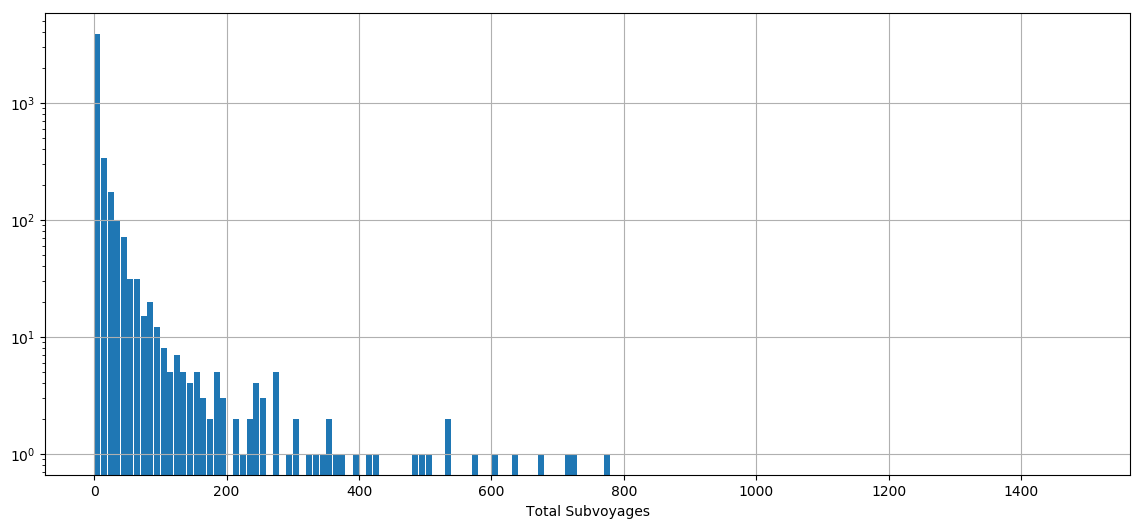

In [38]:
#https://community.modeanalytics.com/python/tutorial/python-histograms-boxplots-and-distributions/

bin_values = np.arange(start=0, stop=1500, step=10)
#print(bin_values)
print("Mean is:", resultframe_Data1.total_SubVoyages.mean())
print("Median is:", resultframe_Data1.total_SubVoyages.median())
resultframe_Data1['total_SubVoyages']
resultframe_Data1['total_SubVoyages'].hist(bins=bin_values, rwidth=0.9 ,figsize=[14,6])
plt.xlabel('Total Subvoyages');
plt.yscale('log',basey=10) 
#plt.hist(resultframe1['total_SubVoyages'], bins=(bin_values))
plt.show()

# Counting Technique

In [39]:
# result_frame["Stopped"] = result_frame["rolling_mean"].isnull() | (result_frame["rolling_mean"] > 0.5)
# result_frame["subVoyageIDs"] = ((result_frame["Stopped"].shift(1) != result_frame["Stopped"]) | (result_frame["rolling_mean"] < 0.5)).astype(int).cumsum() 
# display('Unique subVoyageIDs:', len(result_frame.subVoyageIDs.unique()))

df_test['Stopped']= df_test.groupby('VoyageID').apply(lambda x: x.rolling_mean.isnull()).values | df_test.groupby('VoyageID').apply(lambda x: x.rolling_mean >= 0.5).values
df_test['Stopped_Count']= df_test.groupby('VoyageID').apply(lambda x: x.Stopped.mask(x.Stopped.groupby((x.Stopped).cumsum().where(~x.Stopped)).transform('count') < 10, ~x.Stopped)).values
df_test['subVoyageIDs']= (df_test.groupby('VoyageID').apply(lambda x:x.Stopped_Count.shift(1)) != df_test.groupby('VoyageID').apply(lambda x:x.Stopped_Count) | (df_test.groupby('VoyageID').apply(lambda x: x.rolling_mean <= 0.5).values)).astype(int).cumsum().values
print('Unique subVoyageIDs:', len(df_test.subVoyageIDs.unique()))
# display(df_test.head())
df_testResult= df_test[df_test['Stopped'] == True]

Unique subVoyageIDs: 10690503


In [40]:
df_threshold = df_test.set_index(pd.DatetimeIndex(result_frame.DateTime))

In [41]:
dataPoints = df_testResult.set_index(pd.DatetimeIndex(df_testResult.DateTime))
dataPoints= dataPoints.rename(columns={"index": "indexCol"})

In [42]:
df_CenteredWin =  dataPoints

In [43]:
datapoints= df_CenteredWin.groupby('subVoyageIDs').agg({'Speed':'count'}).reset_index().rename(columns ={'Speed':'totalPoints'})
datapoints = datapoints[datapoints.totalPoints < 10]

In [44]:
df_CenteredWin = df_CenteredWin[~(df_CenteredWin.subVoyageIDs.isin(datapoints.subVoyageIDs.unique()))]
# df_CenteredWin.groupby(['VoyageID','subVoyageIDs']).agg({'VoyageID':'count'})
# # ['subVoyageIDs'].count()

In [45]:
grouped = df_CenteredWin.groupby(['VoyageID', 'subVoyageIDs'])
grouped_count = grouped['subVoyageIDs'].count().reset_index(name="count")
# grouped_count = grouped_count[grouped_count['count'] > 1]
resultframe_Data1 = grouped_count.VoyageID.value_counts().nlargest(12141).reset_index(name = 'total_SubVoyages').rename(columns={"index": "VoyageID"})
resultframe_Data1

,VoyageID,total_SubVoyages
0,226,461
1,140,446
2,282,445
3,131,417
4,218,392
5,349,377
6,55,348
7,121,327
8,157,327
9,57,316


Mean is: 8.746522731990865
Median is: 1.0


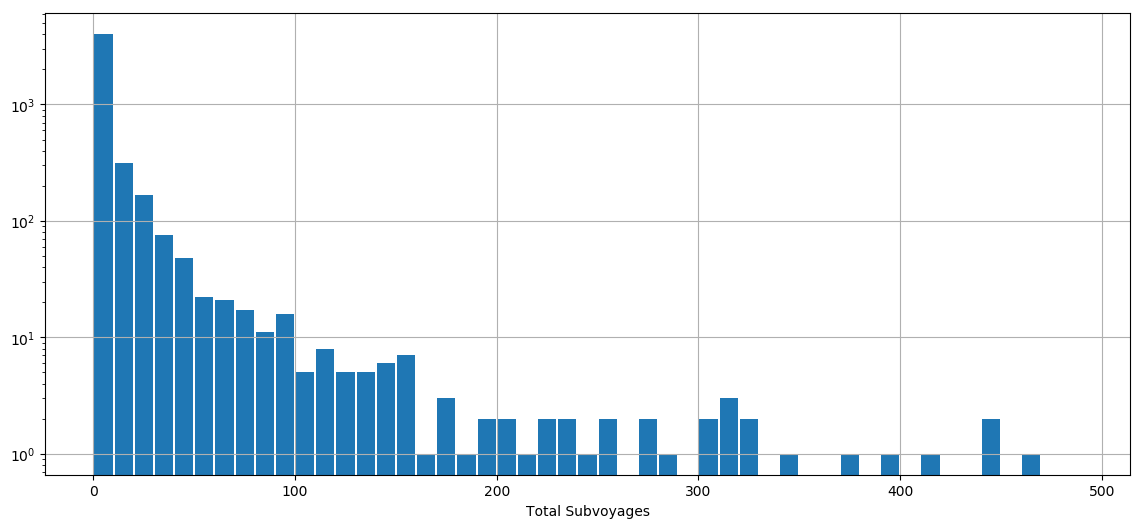

In [46]:
#https://community.modeanalytics.com/python/tutorial/python-histograms-boxplots-and-distributions/

bin_values = np.arange(start=0, stop=500, step=10)
#print(bin_values)
print("Mean is:", resultframe_Data1.total_SubVoyages.mean())
print("Median is:", resultframe_Data1.total_SubVoyages.median())
resultframe_Data1['total_SubVoyages']
resultframe_Data1['total_SubVoyages'].hist(bins=bin_values, rwidth=0.9 ,figsize=[14,6])
plt.xlabel('Total Subvoyages');
plt.yscale('log',basey=10) 
#plt.hist(resultframe1['total_SubVoyages'], bins=(bin_values))
plt.show()

In [47]:
# result_frame["Stopped"] = result_frame["rolling_mean"].isnull() | (result_frame["rolling_mean"] > 0.5)
# result_frame["subVoyageIDs"] = ((result_frame["Stopped"].shift(1) != result_frame["Stopped"]) | (result_frame["rolling_mean"] < 0.5)).astype(int).cumsum() 
# display('Unique subVoyageIDs:', len(result_frame.subVoyageIDs.unique()))

df_test['Stopped']= df_test.groupby('VoyageID').apply(lambda x: x.rolling_mean.isnull()).values | df_test.groupby('VoyageID').apply(lambda x: x.rolling_mean >= 0.4).values
df_test['Stopped_Count']= df_test.groupby('VoyageID').apply(lambda x: x.Stopped.mask(x.Stopped.groupby((x.Stopped).cumsum().where(~x.Stopped)).transform('count') < 10, ~x.Stopped)).values
df_test['subVoyageIDs']= (df_test.groupby('VoyageID').apply(lambda x:x.Stopped_Count.shift(1)) != df_test.groupby('VoyageID').apply(lambda x:x.Stopped_Count) | (df_test.groupby('VoyageID').apply(lambda x: x.rolling_mean <= 0.4).values)).astype(int).cumsum().values
print('Unique subVoyageIDs:', len(df_test.subVoyageIDs.unique()))
# display(df_test.head())
df_testResult= df_test[df_test['Stopped'] == True]

Unique subVoyageIDs: 10384326


In [48]:
df_threshold = df_test.set_index(pd.DatetimeIndex(result_frame.DateTime))

In [49]:
dataPoints = df_testResult.set_index(pd.DatetimeIndex(df_testResult.DateTime))
dataPoints= dataPoints.rename(columns={"index": "indexCol"})

In [50]:
df_CenteredWin =  dataPoints

In [51]:
datapoints= df_CenteredWin.groupby('subVoyageIDs').agg({'Speed':'count'}).reset_index().rename(columns ={'Speed':'totalPoints'})
datapoints = datapoints[datapoints.totalPoints < 10]

In [52]:
df_CenteredWin = df_CenteredWin[~(df_CenteredWin.subVoyageIDs.isin(datapoints.subVoyageIDs.unique()))]
# df_CenteredWin.groupby(['VoyageID','subVoyageIDs']).agg({'VoyageID':'count'})
# # ['subVoyageIDs'].count()

In [53]:
grouped = df_CenteredWin.groupby(['VoyageID', 'subVoyageIDs'])
grouped_count = grouped['subVoyageIDs'].count().reset_index(name="count")
# grouped_count = grouped_count[grouped_count['count'] > 1]
resultframe_Data1 = grouped_count.VoyageID.value_counts().nlargest(12141).reset_index(name = 'total_SubVoyages').rename(columns={"index": "VoyageID"})
resultframe_Data1

,VoyageID,total_SubVoyages
0,226,462
1,140,433
2,282,428
3,131,404
4,70,388
5,349,387
6,218,366
7,55,334
8,306,314
9,57,312


Mean is: 9.34700642220841
Median is: 2.0


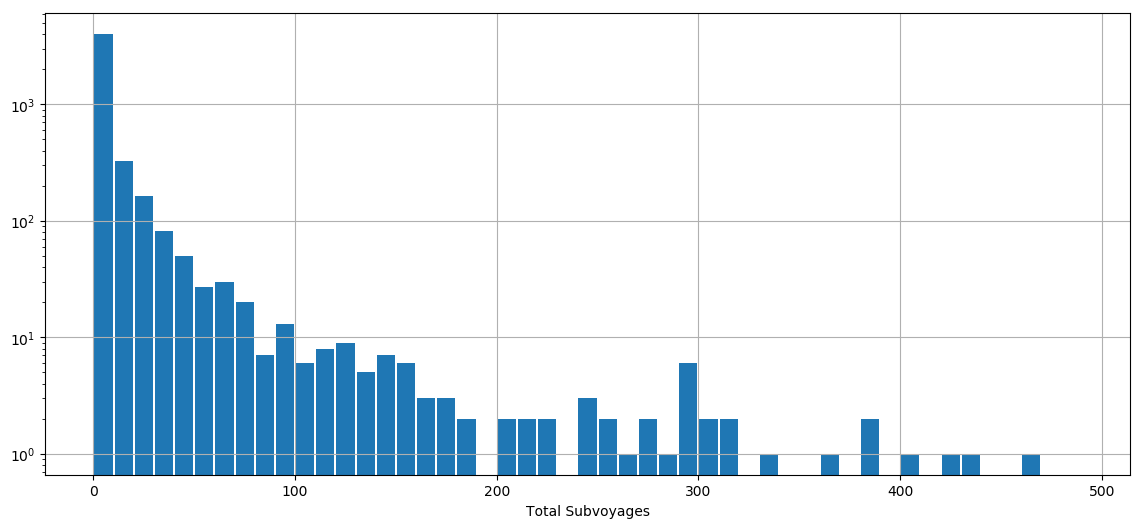

In [54]:
#https://community.modeanalytics.com/python/tutorial/python-histograms-boxplots-and-distributions/

bin_values = np.arange(start=0, stop=500, step=10)
#print(bin_values)
print("Mean is:", resultframe_Data1.total_SubVoyages.mean())
print("Median is:", resultframe_Data1.total_SubVoyages.median())
resultframe_Data1['total_SubVoyages']
resultframe_Data1['total_SubVoyages'].hist(bins=bin_values, rwidth=0.9 ,figsize=[14,6])
plt.xlabel('Total Subvoyages');
plt.yscale('log',basey=10) 
#plt.hist(resultframe1['total_SubVoyages'], bins=(bin_values))
plt.show()

In [55]:
# result_frame["Stopped"] = result_frame["rolling_mean"].isnull() | (result_frame["rolling_mean"] > 0.5)
# result_frame["subVoyageIDs"] = ((result_frame["Stopped"].shift(1) != result_frame["Stopped"]) | (result_frame["rolling_mean"] < 0.5)).astype(int).cumsum() 
# display('Unique subVoyageIDs:', len(result_frame.subVoyageIDs.unique()))

df_test['Stopped']= df_test.groupby('VoyageID').apply(lambda x: x.rolling_mean.isnull()).values | df_test.groupby('VoyageID').apply(lambda x: x.rolling_mean >= 0.7).values
df_test['Stopped_Count']= df_test.groupby('VoyageID').apply(lambda x: x.Stopped.mask(x.Stopped.groupby((x.Stopped).cumsum().where(~x.Stopped)).transform('count') < 10, ~x.Stopped)).values
df_test['subVoyageIDs']= (df_test.groupby('VoyageID').apply(lambda x:x.Stopped_Count.shift(1)) != df_test.groupby('VoyageID').apply(lambda x:x.Stopped_Count) | (df_test.groupby('VoyageID').apply(lambda x: x.rolling_mean <= 0.7).values)).astype(int).cumsum().values
print('Unique subVoyageIDs:', len(df_test.subVoyageIDs.unique()))
# display(df_test.head())
df_testResult= df_test[df_test['Stopped'] == True]

Unique subVoyageIDs: 10967155


In [56]:
df_threshold = df_test.set_index(pd.DatetimeIndex(result_frame.DateTime))

In [57]:
dataPoints = df_testResult.set_index(pd.DatetimeIndex(df_testResult.DateTime))
dataPoints= dataPoints.rename(columns={"index": "indexCol"})

In [58]:
df_CenteredWin =  dataPoints

In [59]:
datapoints= df_CenteredWin.groupby('subVoyageIDs').agg({'Speed':'count'}).reset_index().rename(columns ={'Speed':'totalPoints'})
datapoints = datapoints[datapoints.totalPoints < 10]

In [60]:
df_CenteredWin = df_CenteredWin[~(df_CenteredWin.subVoyageIDs.isin(datapoints.subVoyageIDs.unique()))]
# df_CenteredWin.groupby(['VoyageID','subVoyageIDs']).agg({'VoyageID':'count'})
# # ['subVoyageIDs'].count()

In [61]:
grouped = df_CenteredWin.groupby(['VoyageID', 'subVoyageIDs'])
grouped_count = grouped['subVoyageIDs'].count().reset_index(name="count")
# grouped_count = grouped_count[grouped_count['count'] > 1]
resultframe_Data1 = grouped_count.VoyageID.value_counts().nlargest(12141).reset_index(name = 'total_SubVoyages').rename(columns={"index": "VoyageID"})
resultframe_Data1

,VoyageID,total_SubVoyages
0,140,459
1,226,457
2,282,456
3,131,427
4,218,412
5,55,374
6,121,373
7,349,368
8,183,339
9,179,337


Mean is: 8.336314475873545
Median is: 1.0


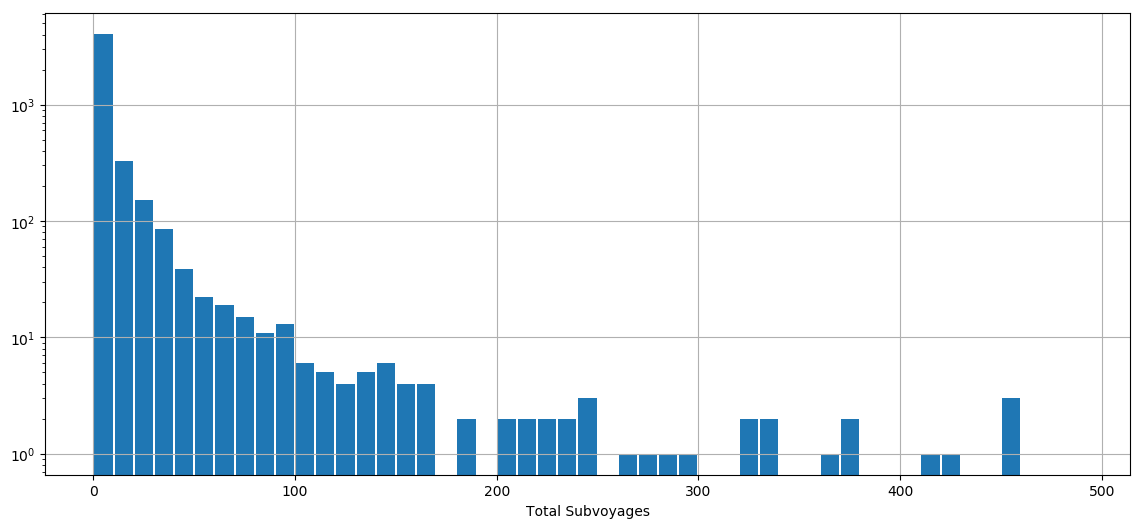

In [62]:
#https://community.modeanalytics.com/python/tutorial/python-histograms-boxplots-and-distributions/

bin_values = np.arange(start=0, stop=500, step=10)
#print(bin_values)
print("Mean is:", resultframe_Data1.total_SubVoyages.mean())
print("Median is:", resultframe_Data1.total_SubVoyages.median())
resultframe_Data1['total_SubVoyages']
resultframe_Data1['total_SubVoyages'].hist(bins=bin_values, rwidth=0.9 ,figsize=[14,6])
plt.xlabel('Total Subvoyages');
plt.yscale('log',basey=10) 
#plt.hist(resultframe1['total_SubVoyages'], bins=(bin_values))
plt.show()

In [63]:
# result_frame["Stopped"] = result_frame["rolling_mean"].isnull() | (result_frame["rolling_mean"] > 0.5)
# result_frame["subVoyageIDs"] = ((result_frame["Stopped"].shift(1) != result_frame["Stopped"]) | (result_frame["rolling_mean"] < 0.5)).astype(int).cumsum() 
# display('Unique subVoyageIDs:', len(result_frame.subVoyageIDs.unique()))

df_test['Stopped']= df_test.groupby('VoyageID').apply(lambda x: x.rolling_mean.isnull()).values | df_test.groupby('VoyageID').apply(lambda x: x.rolling_mean >= 1.0).values
df_test['Stopped_Count']= df_test.groupby('VoyageID').apply(lambda x: x.Stopped.mask(x.Stopped.groupby((x.Stopped).cumsum().where(~x.Stopped)).transform('count') < 10, ~x.Stopped)).values
df_test['subVoyageIDs']= (df_test.groupby('VoyageID').apply(lambda x:x.Stopped_Count.shift(1)) != df_test.groupby('VoyageID').apply(lambda x:x.Stopped_Count) | (df_test.groupby('VoyageID').apply(lambda x: x.rolling_mean <= 1.0).values)).astype(int).cumsum().values
print('Unique subVoyageIDs:', len(df_test.subVoyageIDs.unique()))
# display(df_test.head())
df_testResult= df_test[df_test['Stopped'] == True]

Unique subVoyageIDs: 11179829


In [64]:
df_threshold = df_test.set_index(pd.DatetimeIndex(result_frame.DateTime))

In [65]:
dataPoints = df_testResult.set_index(pd.DatetimeIndex(df_testResult.DateTime))
dataPoints= dataPoints.rename(columns={"index": "indexCol"})

In [66]:
df_CenteredWin =  dataPoints

In [67]:
datapoints= df_CenteredWin.groupby('subVoyageIDs').agg({'Speed':'count'}).reset_index().rename(columns ={'Speed':'totalPoints'})
datapoints = datapoints[datapoints.totalPoints < 10]

In [68]:
df_CenteredWin = df_CenteredWin[~(df_CenteredWin.subVoyageIDs.isin(datapoints.subVoyageIDs.unique()))]
# df_CenteredWin.groupby(['VoyageID','subVoyageIDs']).agg({'VoyageID':'count'})
# # ['subVoyageIDs'].count()

In [69]:
grouped = df_CenteredWin.groupby(['VoyageID', 'subVoyageIDs'])
grouped_count = grouped['subVoyageIDs'].count().reset_index(name="count")
# grouped_count = grouped_count[grouped_count['count'] > 1]
resultframe_Data1 = grouped_count.VoyageID.value_counts().nlargest(12141).reset_index(name = 'total_SubVoyages').rename(columns={"index": "VoyageID"})
resultframe_Data1

,VoyageID,total_SubVoyages
0,140,487
1,282,484
2,121,467
3,131,461
4,226,456
5,218,433
6,55,394
7,183,373
8,179,363
9,349,341


Mean is: 8.256100104275287
Median is: 1.0


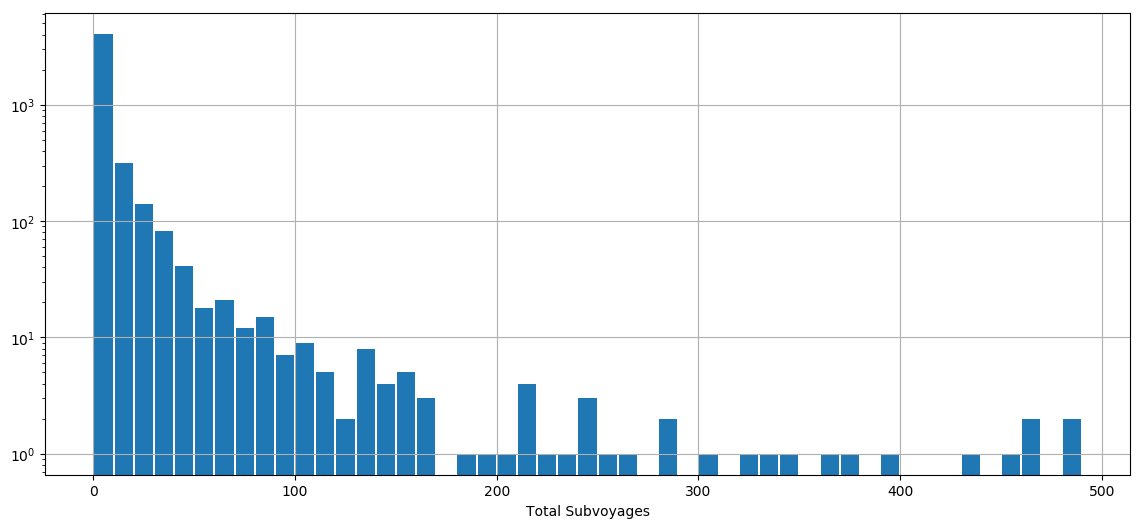

In [70]:
#https://community.modeanalytics.com/python/tutorial/python-histograms-boxplots-and-distributions/

bin_values = np.arange(start=0, stop=500, step=10)
#print(bin_values)
print("Mean is:", resultframe_Data1.total_SubVoyages.mean())
print("Median is:", resultframe_Data1.total_SubVoyages.median())
resultframe_Data1['total_SubVoyages']
resultframe_Data1['total_SubVoyages'].hist(bins=bin_values, rwidth=0.9 ,figsize=[14,6])
plt.xlabel('Total Subvoyages');
plt.yscale('log',basey=10) 
#plt.hist(resultframe1['total_SubVoyages'], bins=(bin_values))
plt.show()

# Threshold Approach

In [106]:
df_test['Stopped']= df_test.groupby('VoyageID').apply(lambda x: x.rolling_mean.isnull()).values | df_test.groupby('VoyageID').apply(lambda x: x.rolling_mean >= 0.4).values
# df_test['Stopped_Count']= df_test.groupby('VoyageID').apply(lambda x: x.Stopped.mask(x.Stopped.groupby((x.Stopped).cumsum().where(~x.Stopped)).transform('count') < 10, ~x.Stopped)).values
df_test['subVoyageIDs']= (df_test.groupby('VoyageID').apply(lambda x:x.Stopped.shift(1)) != df_test.groupby('VoyageID').apply(lambda x:x.Stopped) | (df_test.groupby('VoyageID').apply(lambda x: x.rolling_mean <= 0.4).values)).astype(int).cumsum().values
df_testResult= df_test[df_test['Stopped'] == True]
print('Unique subVoyageIDs:', len(df_testResult.subVoyageIDs.unique()))

Unique subVoyageIDs: 171166


In [107]:
df_test['Stopped']= df_test.groupby('VoyageID').apply(lambda x: x.rolling_mean.isnull()).values | df_test.groupby('VoyageID').apply(lambda x: x.rolling_mean >= 0.5).values
# df_test['Stopped_Count']= df_test.groupby('VoyageID').apply(lambda x: x.Stopped.mask(x.Stopped.groupby((x.Stopped).cumsum().where(~x.Stopped)).transform('count') < 10, ~x.Stopped)).values
df_test['subVoyageIDs']= (df_test.groupby('VoyageID').apply(lambda x:x.Stopped.shift(1)) != df_test.groupby('VoyageID').apply(lambda x:x.Stopped) | (df_test.groupby('VoyageID').apply(lambda x: x.rolling_mean <= 0.5).values)).astype(int).cumsum().values
df_testResult= df_test[df_test['Stopped'] == True]
print('Unique subVoyageIDs:', len(df_testResult.subVoyageIDs.unique()))

Unique subVoyageIDs: 140506


In [108]:
df_test['Stopped']= df_test.groupby('VoyageID').apply(lambda x: x.rolling_mean.isnull()).values | df_test.groupby('VoyageID').apply(lambda x: x.rolling_mean >= 0.7).values
# df_test['Stopped_Count']= df_test.groupby('VoyageID').apply(lambda x: x.Stopped.mask(x.Stopped.groupby((x.Stopped).cumsum().where(~x.Stopped)).transform('count') < 10, ~x.Stopped)).values
df_test['subVoyageIDs']= (df_test.groupby('VoyageID').apply(lambda x:x.Stopped.shift(1)) != df_test.groupby('VoyageID').apply(lambda x:x.Stopped) | (df_test.groupby('VoyageID').apply(lambda x: x.rolling_mean <= 0.7).values)).astype(int).cumsum().values
df_testResult= df_test[df_test['Stopped'] == True]
print('Unique subVoyageIDs:', len(df_testResult.subVoyageIDs.unique()))

Unique subVoyageIDs: 119014


In [109]:
df_test['Stopped']= df_test.groupby('VoyageID').apply(lambda x: x.rolling_mean.isnull()).values | df_test.groupby('VoyageID').apply(lambda x: x.rolling_mean >= 1.0).values
# df_test['Stopped_Count']= df_test.groupby('VoyageID').apply(lambda x: x.Stopped.mask(x.Stopped.groupby((x.Stopped).cumsum().where(~x.Stopped)).transform('count') < 10, ~x.Stopped)).values
df_test['subVoyageIDs']= (df_test.groupby('VoyageID').apply(lambda x:x.Stopped.shift(1)) != df_test.groupby('VoyageID').apply(lambda x:x.Stopped) | (df_test.groupby('VoyageID').apply(lambda x: x.rolling_mean <= 1.0).values)).astype(int).cumsum().values
df_testResult= df_test[df_test['Stopped'] == True]
print('Unique subVoyageIDs:', len(df_testResult.subVoyageIDs.unique()))

Unique subVoyageIDs: 108758


In [110]:
df_test['Stopped']= df_test.groupby('VoyageID').apply(lambda x: x.rolling_mean.isnull()).values | df_test.groupby('VoyageID').apply(lambda x: x.rolling_mean >= 1.2).values
# df_test['Stopped_Count']= df_test.groupby('VoyageID').apply(lambda x: x.Stopped.mask(x.Stopped.groupby((x.Stopped).cumsum().where(~x.Stopped)).transform('count') < 10, ~x.Stopped)).values
df_test['subVoyageIDs']= (df_test.groupby('VoyageID').apply(lambda x:x.Stopped.shift(1)) != df_test.groupby('VoyageID').apply(lambda x:x.Stopped) | (df_test.groupby('VoyageID').apply(lambda x: x.rolling_mean <= 1.2).values)).astype(int).cumsum().values
df_testResult= df_test[df_test['Stopped'] == True]
print('Unique subVoyageIDs:', len(df_testResult.subVoyageIDs.unique()))

Unique subVoyageIDs: 105434


In [111]:
df_test['Stopped']= df_test.groupby('VoyageID').apply(lambda x: x.rolling_mean.isnull()).values | df_test.groupby('VoyageID').apply(lambda x: x.rolling_mean >= 1.4).values
# df_test['Stopped_Count']= df_test.groupby('VoyageID').apply(lambda x: x.Stopped.mask(x.Stopped.groupby((x.Stopped).cumsum().where(~x.Stopped)).transform('count') < 10, ~x.Stopped)).values
df_test['subVoyageIDs']= (df_test.groupby('VoyageID').apply(lambda x:x.Stopped.shift(1)) != df_test.groupby('VoyageID').apply(lambda x:x.Stopped) | (df_test.groupby('VoyageID').apply(lambda x: x.rolling_mean <= 1.4).values)).astype(int).cumsum().values
df_testResult= df_test[df_test['Stopped'] == True]
print('Unique subVoyageIDs:', len(df_testResult.subVoyageIDs.unique()))

Unique subVoyageIDs: 103630


In [112]:
df_test['Stopped']= df_test.groupby('VoyageID').apply(lambda x: x.rolling_mean.isnull()).values | df_test.groupby('VoyageID').apply(lambda x: x.rolling_mean >= 1.6).values
# df_test['Stopped_Count']= df_test.groupby('VoyageID').apply(lambda x: x.Stopped.mask(x.Stopped.groupby((x.Stopped).cumsum().where(~x.Stopped)).transform('count') < 10, ~x.Stopped)).values
df_test['subVoyageIDs']= (df_test.groupby('VoyageID').apply(lambda x:x.Stopped.shift(1)) != df_test.groupby('VoyageID').apply(lambda x:x.Stopped) | (df_test.groupby('VoyageID').apply(lambda x: x.rolling_mean <= 1.6).values)).astype(int).cumsum().values
df_testResult= df_test[df_test['Stopped'] == True]
print('Unique subVoyageIDs:', len(df_testResult.subVoyageIDs.unique()))

Unique subVoyageIDs: 101924


In [113]:
df_test['Stopped']= df_test.groupby('VoyageID').apply(lambda x: x.rolling_mean.isnull()).values | df_test.groupby('VoyageID').apply(lambda x: x.rolling_mean >= 1.8).values
# df_test['Stopped_Count']= df_test.groupby('VoyageID').apply(lambda x: x.Stopped.mask(x.Stopped.groupby((x.Stopped).cumsum().where(~x.Stopped)).transform('count') < 10, ~x.Stopped)).values
df_test['subVoyageIDs']= (df_test.groupby('VoyageID').apply(lambda x:x.Stopped.shift(1)) != df_test.groupby('VoyageID').apply(lambda x:x.Stopped) | (df_test.groupby('VoyageID').apply(lambda x: x.rolling_mean <= 1.8).values)).astype(int).cumsum().values
df_testResult= df_test[df_test['Stopped'] == True]
print('Unique subVoyageIDs:', len(df_testResult.subVoyageIDs.unique()))

Unique subVoyageIDs: 100782


In [114]:
df_test['Stopped']= df_test.groupby('VoyageID').apply(lambda x: x.rolling_mean.isnull()).values | df_test.groupby('VoyageID').apply(lambda x: x.rolling_mean >= 2.0).values
# df_test['Stopped_Count']= df_test.groupby('VoyageID').apply(lambda x: x.Stopped.mask(x.Stopped.groupby((x.Stopped).cumsum().where(~x.Stopped)).transform('count') < 10, ~x.Stopped)).values
df_test['subVoyageIDs']= (df_test.groupby('VoyageID').apply(lambda x:x.Stopped.shift(1)) != df_test.groupby('VoyageID').apply(lambda x:x.Stopped) | (df_test.groupby('VoyageID').apply(lambda x: x.rolling_mean <= 2.0).values)).astype(int).cumsum().values
df_testResult= df_test[df_test['Stopped'] == True]
print('Unique subVoyageIDs:', len(df_testResult.subVoyageIDs.unique()))

Unique subVoyageIDs: 99155


# Counting Approach

In [115]:
df_test['Stopped']= df_test.groupby('VoyageID').apply(lambda x: x.rolling_mean.isnull()).values | df_test.groupby('VoyageID').apply(lambda x: x.rolling_mean >= 0.4).values
df_test['Stopped_Count']= df_test.groupby('VoyageID').apply(lambda x: x.Stopped.mask(x.Stopped.groupby((x.Stopped).cumsum().where(~x.Stopped)).transform('count') < 10, ~x.Stopped)).values
df_test['subVoyageIDs']= (df_test.groupby('VoyageID').apply(lambda x:x.Stopped_Count.shift(1)) != df_test.groupby('VoyageID').apply(lambda x:x.Stopped_Count) | (df_test.groupby('VoyageID').apply(lambda x: x.rolling_mean <= 0.4).values)).astype(int).cumsum().values
df_testResult= df_test[df_test['Stopped'] == True]
print('Unique subVoyageIDs:', len(df_testResult.subVoyageIDs.unique()))

Unique subVoyageIDs: 83131


In [127]:
df_test['Stopped']= df_test.groupby('VoyageID').apply(lambda x: x.rolling_mean.isnull()).values | df_test.groupby('VoyageID').apply(lambda x: x.rolling_mean >= 0.7).values
df_test['Stopped_Count']= df_test.groupby('VoyageID').apply(lambda x: x.Stopped.mask(x.Stopped.groupby((x.Stopped).cumsum().where(~x.Stopped)).transform('count') < 10, ~x.Stopped)).values
df_test['subVoyageIDs']= (df_test.groupby('VoyageID').apply(lambda x:x.Stopped_Count.shift(1)) != df_test.groupby('VoyageID').apply(lambda x:x.Stopped_Count) | (df_test.groupby('VoyageID').apply(lambda x: x.rolling_mean <= 0.7).values)).astype(int).cumsum().values
df_testResult= df_test[df_test['Stopped'] == True]
print('Unique subVoyageIDs:', len(df_testResult.subVoyageIDs.unique()))

Unique subVoyageIDs: 59668


In [118]:
df_test['Stopped']= df_test.groupby('VoyageID').apply(lambda x: x.rolling_mean.isnull()).values | df_test.groupby('VoyageID').apply(lambda x: x.rolling_mean >= 1.0).values
df_test['Stopped_Count']= df_test.groupby('VoyageID').apply(lambda x: x.Stopped.mask(x.Stopped.groupby((x.Stopped).cumsum().where(~x.Stopped)).transform('count') < 10, ~x.Stopped)).values
df_test['subVoyageIDs']= (df_test.groupby('VoyageID').apply(lambda x:x.Stopped_Count.shift(1)) != df_test.groupby('VoyageID').apply(lambda x:x.Stopped_Count) | (df_test.groupby('VoyageID').apply(lambda x: x.rolling_mean <= 1.0).values)).astype(int).cumsum().values
df_testResult= df_test[df_test['Stopped'] == True]
print('Unique subVoyageIDs:', len(df_testResult.subVoyageIDs.unique()))

Unique subVoyageIDs: 55707


In [119]:
df_test['Stopped']= df_test.groupby('VoyageID').apply(lambda x: x.rolling_mean.isnull()).values | df_test.groupby('VoyageID').apply(lambda x: x.rolling_mean >= 1.2).values
df_test['Stopped_Count']= df_test.groupby('VoyageID').apply(lambda x: x.Stopped.mask(x.Stopped.groupby((x.Stopped).cumsum().where(~x.Stopped)).transform('count') < 10, ~x.Stopped)).values
df_test['subVoyageIDs']= (df_test.groupby('VoyageID').apply(lambda x:x.Stopped_Count.shift(1)) != df_test.groupby('VoyageID').apply(lambda x:x.Stopped_Count) | (df_test.groupby('VoyageID').apply(lambda x: x.rolling_mean <= 1.2).values)).astype(int).cumsum().values
df_testResult= df_test[df_test['Stopped'] == True]
print('Unique subVoyageIDs:', len(df_testResult.subVoyageIDs.unique()))

Unique subVoyageIDs: 55148


In [120]:
df_test['Stopped']= df_test.groupby('VoyageID').apply(lambda x: x.rolling_mean.isnull()).values | df_test.groupby('VoyageID').apply(lambda x: x.rolling_mean >= 1.4).values
df_test['Stopped_Count']= df_test.groupby('VoyageID').apply(lambda x: x.Stopped.mask(x.Stopped.groupby((x.Stopped).cumsum().where(~x.Stopped)).transform('count') < 10, ~x.Stopped)).values
df_test['subVoyageIDs']= (df_test.groupby('VoyageID').apply(lambda x:x.Stopped_Count.shift(1)) != df_test.groupby('VoyageID').apply(lambda x:x.Stopped_Count) | (df_test.groupby('VoyageID').apply(lambda x: x.rolling_mean <= 1.4).values)).astype(int).cumsum().values
df_testResult= df_test[df_test['Stopped'] == True]
print('Unique subVoyageIDs:', len(df_testResult.subVoyageIDs.unique()))

Unique subVoyageIDs: 55137


In [121]:
df_test['Stopped']= df_test.groupby('VoyageID').apply(lambda x: x.rolling_mean.isnull()).values | df_test.groupby('VoyageID').apply(lambda x: x.rolling_mean >= 1.6).values
df_test['Stopped_Count']= df_test.groupby('VoyageID').apply(lambda x: x.Stopped.mask(x.Stopped.groupby((x.Stopped).cumsum().where(~x.Stopped)).transform('count') < 10, ~x.Stopped)).values
df_test['subVoyageIDs']= (df_test.groupby('VoyageID').apply(lambda x:x.Stopped_Count.shift(1)) != df_test.groupby('VoyageID').apply(lambda x:x.Stopped_Count) | (df_test.groupby('VoyageID').apply(lambda x: x.rolling_mean <= 1.6).values)).astype(int).cumsum().values
df_testResult= df_test[df_test['Stopped'] == True]
print('Unique subVoyageIDs:', len(df_testResult.subVoyageIDs.unique()))

Unique subVoyageIDs: 55278


In [122]:
df_test['Stopped']= df_test.groupby('VoyageID').apply(lambda x: x.rolling_mean.isnull()).values | df_test.groupby('VoyageID').apply(lambda x: x.rolling_mean >= 1.8).values
df_test['Stopped_Count']= df_test.groupby('VoyageID').apply(lambda x: x.Stopped.mask(x.Stopped.groupby((x.Stopped).cumsum().where(~x.Stopped)).transform('count') < 10, ~x.Stopped)).values
df_test['subVoyageIDs']= (df_test.groupby('VoyageID').apply(lambda x:x.Stopped_Count.shift(1)) != df_test.groupby('VoyageID').apply(lambda x:x.Stopped_Count) | (df_test.groupby('VoyageID').apply(lambda x: x.rolling_mean <= 1.8).values)).astype(int).cumsum().values
df_testResult= df_test[df_test['Stopped'] == True]
print('Unique subVoyageIDs:', len(df_testResult.subVoyageIDs.unique()))

Unique subVoyageIDs: 55565


In [123]:
df_test['Stopped']= df_test.groupby('VoyageID').apply(lambda x: x.rolling_mean.isnull()).values | df_test.groupby('VoyageID').apply(lambda x: x.rolling_mean >= 2.0).values
df_test['Stopped_Count']= df_test.groupby('VoyageID').apply(lambda x: x.Stopped.mask(x.Stopped.groupby((x.Stopped).cumsum().where(~x.Stopped)).transform('count') < 10, ~x.Stopped)).values
df_test['subVoyageIDs']= (df_test.groupby('VoyageID').apply(lambda x:x.Stopped_Count.shift(1)) != df_test.groupby('VoyageID').apply(lambda x:x.Stopped_Count) | (df_test.groupby('VoyageID').apply(lambda x: x.rolling_mean <= 2.0).values)).astype(int).cumsum().values
df_testResult= df_test[df_test['Stopped'] == True]
print('Unique subVoyageIDs:', len(df_testResult.subVoyageIDs.unique()))

Unique subVoyageIDs: 55734


In [100]:
# at rolligmean value 30 
# uniquevalue_thresholdVal = pd.DataFrame()
d = {'uniquesubV_threshold': [10707805, 10951876, 11191109, 11385891, 11475927, 11550237, 11615007, 11673346, 11725829],'uniquesubV_counting': [10384326, 10690503, 10967155, 11179829, 11277684, 11357662, 11427859, 11491513, 11550937], 'threshold_val': [0.4, 0.5, 0.7, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]}
df_distribution = pd.DataFrame(data=d)
df_distribution

,threshold_val,uniquesubV_counting,uniquesubV_threshold
0,0.4,10384326,10707805
1,0.5,10690503,10951876
2,0.7,10967155,11191109
3,1.0,11179829,11385891
4,1.2,11277684,11475927
5,1.4,11357662,11550237
6,1.6,11427859,11615007
7,1.8,11491513,11673346
8,2.0,11550937,11725829


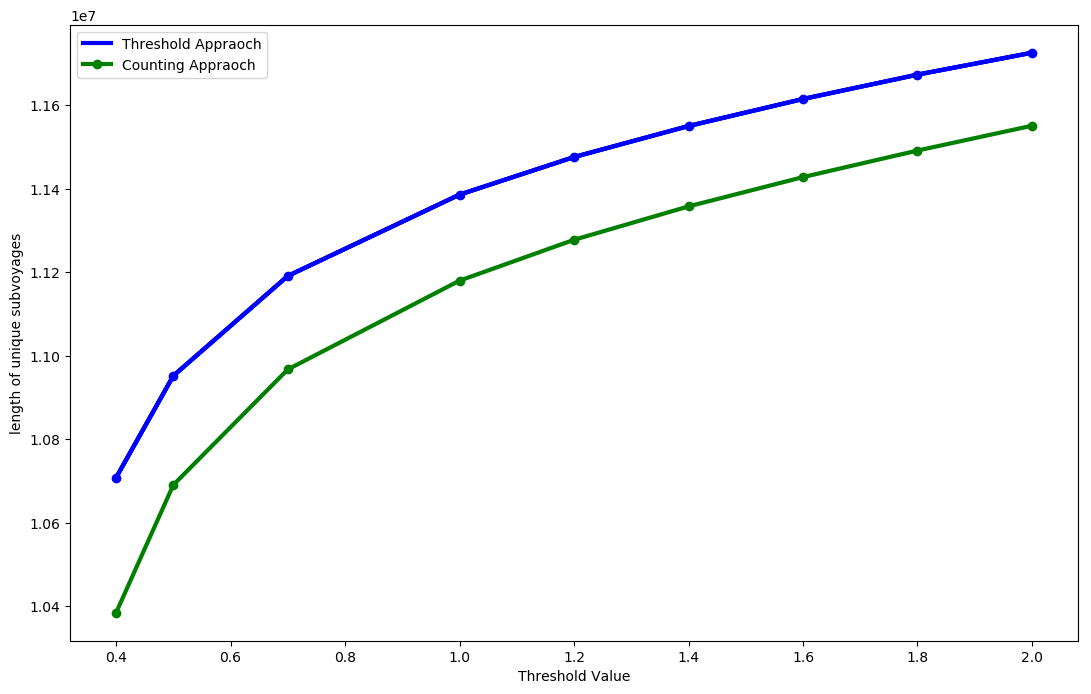

In [104]:
plt.plot(df_distribution.threshold_val, df_distribution.uniquesubV_threshold, marker='o', linestyle='-', linewidth=3.0, color='b', label='Threshold Appraoch')
plt.plot(df_distribution.threshold_val, df_distribution.uniquesubV_counting, marker='o', linewidth=3.0 , linestyle='-', color='g', label='Counting Appraoch')
#plt.xticks(np.arange(min(x), max(x)+1, 1.0))
plt.ylabel('length of unique subvoyages')
plt.xlabel('Threshold Value') 
# plt.rcParams['figure.figsize'] = 13,8
plt.legend()
plt.show()

In [124]:
# at rolligmean value 30 
# uniquevalue_thresholdVal = pd.DataFrame()
d = {'uniquesubV_threshold': [171166, 140506, 119014, 108758, 105434, 103630, 101924, 100782, 99155],'uniquesubV_counting': [83131, 70242, 59668, 55707, 55148, 55137, 55278, 55565, 55734], 'threshold_val': [0.4, 0.5, 0.7, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]}
df_distribution = pd.DataFrame(data=d)
df_distribution

,threshold_val,uniquesubV_counting,uniquesubV_threshold
0,0.4,83131,171166
1,0.5,70242,140506
2,0.7,59668,119014
3,1.0,55707,108758
4,1.2,55148,105434
5,1.4,55137,103630
6,1.6,55278,101924
7,1.8,55565,100782
8,2.0,55734,99155


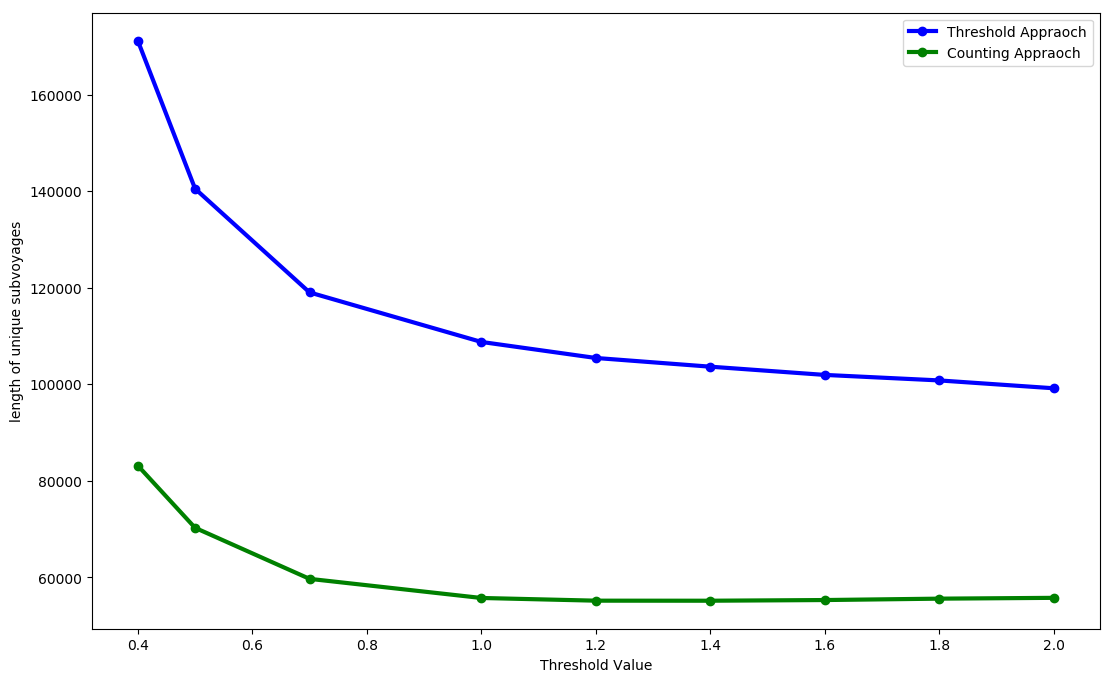

In [125]:
plt.plot(df_distribution.threshold_val, df_distribution.uniquesubV_threshold, marker='o', linestyle='-', linewidth=3.0, color='b', label='Threshold Appraoch')
plt.plot(df_distribution.threshold_val, df_distribution.uniquesubV_counting, marker='o', linewidth=3.0 , linestyle='-', color='g', label='Counting Appraoch')
#plt.xticks(np.arange(min(x), max(x)+1, 1.0))
plt.ylabel('length of unique subvoyages')
plt.xlabel('Threshold Value') 
# plt.rcParams['figure.figsize'] = 13,8
plt.legend()
plt.show()

# Total Reporting Time of subVoyages

In [55]:
# timeStamps= (df_testResult.DateTime.diff().dt.seconds/60).reset_index(name ="timeStamps")

In [62]:
timeStamps= (df_testResult.groupby('subVoyageIDs').apply(lambda x: x.DateTime.diff().dt.seconds/60) ).reset_index(name ="timeStamps")

In [228]:
len(timeStamps)

5999948

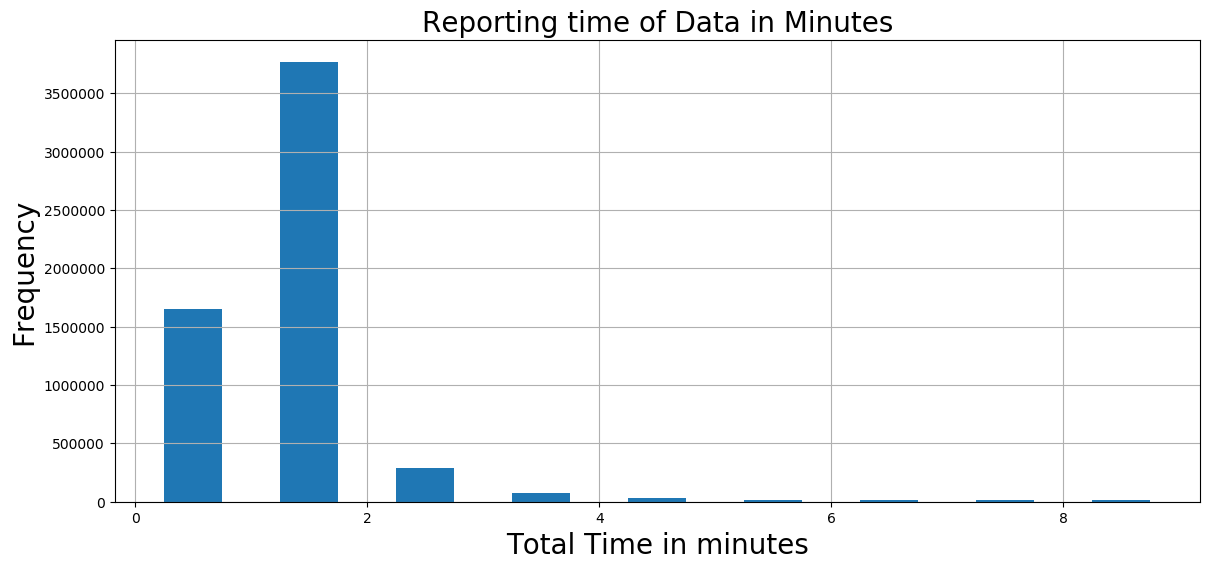

In [233]:
fig, ax = plt.subplots()
bin_values = np.arange(start=0, stop= 10, step= 1)
timeStamps['timeStamps'].hist(bins=bin_values, rwidth=0.5 ,figsize=[14,6])
# plt.xscale('log', nonposy='clip')
# plt.yscale('log', nonposy='clip')
plt.title("Reporting time of Data in Minutes", fontsize= 20)
plt.xlabel("Total Time in minutes", fontsize= 20)
plt.ylabel("Frequency", fontsize= 20)
plt.yscale('linear')
# plt.set_title('linear')

plt.show()

In [68]:
df_test['Stopped']= df_test.groupby('VoyageID').apply(lambda x: x.rolling_mean.isnull()).values | df_test.groupby('VoyageID').apply(lambda x: x.rolling_mean >= 0.5).values
df_test['Stopped_Count']= df_test.groupby('VoyageID').apply(lambda x: x.Stopped.mask(x.Stopped.groupby((x.Stopped).cumsum().where(~x.Stopped)).transform('count') < 10, ~x.Stopped)).values
df_test['subVoyageIDs']= (df_test.groupby('VoyageID').apply(lambda x:x.Stopped_Count.shift(1)) != df_test.groupby('VoyageID').apply(lambda x:x.Stopped_Count) | (df_test.groupby('VoyageID').apply(lambda x: x.rolling_mean <= 0.5).values)).astype(int).cumsum().values
df_testResult= df_test[df_test['Stopped'] == True]

In [69]:
dataPoints = df_testResult.set_index(pd.DatetimeIndex(df_testResult.DateTime))
dataPoints= dataPoints.rename(columns={"index": "indexCol"})

In [70]:
df_CenteredWin =  dataPoints

In [71]:
datapoints= df_CenteredWin.groupby('subVoyageIDs').agg({'Speed':'count'}).reset_index().rename(columns ={'Speed':'totalPoints'})
datapoints = datapoints[datapoints.totalPoints < 10]
shrtTraje = dataPoints
len(shrtTraje.subVoyageIDs.unique())

70242

In [72]:
df_CenteredWin = df_CenteredWin[~(df_CenteredWin.subVoyageIDs.isin(datapoints.subVoyageIDs.unique()))]

In [73]:
len(df_CenteredWin.subVoyageIDs.unique())

42132

# Breaking into time data

In [74]:
df_CenteredWin['noise_timegaps']= df_CenteredWin.groupby('subVoyageIDs').apply(lambda x: (x.DateTime.diff().dt.seconds/3600 > 1)).values
df_CenteredWin['sub_subVoyageIDs']=  (df_CenteredWin.groupby('subVoyageIDs').apply(lambda x:x.noise_timegaps.shift(1)) != df_CenteredWin.groupby('subVoyageIDs').apply(lambda x:x.noise_timegaps) | (df_CenteredWin.groupby('subVoyageIDs').apply(lambda x: x.DateTime.diff().dt.seconds/3600 > 1).values)).astype(int).cumsum().values

In [75]:
len(df_CenteredWin.sub_subVoyageIDs.unique())

63882

In [76]:
total_Points = df_CenteredWin.groupby('sub_subVoyageIDs').agg({'Speed':'count'}).reset_index().rename(columns={'Speed':'totalPoints'})
total_Points = total_Points[total_Points.totalPoints > 10]
df_CenteredWin = df_CenteredWin[df_CenteredWin.sub_subVoyageIDs.isin(total_Points.sub_subVoyageIDs.unique())]

In [77]:
display(len(df_CenteredWin.sub_subVoyageIDs.unique()))

47340

# Creating new dataframe and applying Z-Score

In [78]:
dfdata = pd.DataFrame(data = {'MMSI' : df_CenteredWin.MMSI, 
                        'VoyageID' : df_CenteredWin.VoyageID,
                        'subVoyageIDs' : df_CenteredWin.subVoyageIDs,
                        'indexCol' : df_CenteredWin.indexCol,
                        'subVoyageIDs_subV' : df_CenteredWin.sub_subVoyageIDs,
                        'indexCol': df_CenteredWin.indexCol,
                        'DateTime' : df_CenteredWin.DateTime,
                        'distance' : df_CenteredWin.Distance,
                        'Speed' : df_CenteredWin.Speed,
                        'totalHours' : df_CenteredWin.totalHours,
                        'lat' : df_CenteredWin.lat,
                        'lon' :  df_CenteredWin.lon})

In [79]:
def centerMeanWin(data):
    max_timestamp= pd.Timestamp(data.DateTime.max())
    min_timestamp= pd.Timestamp(data.DateTime.min())
    period = '30T'
    reverse_df = data.set_index(max_timestamp - (data.index - min_timestamp)).sort_index()
    win_left = reverse_df.Speed.rolling(period, closed='left').sum()
    win_left= win_left.reset_index()
    win_left= win_left.set_index(pd.DatetimeIndex(win_left.DateTime))
    count_Left= win_left.Speed.rolling(period).count()
    win_left = win_left.set_index(min_timestamp + (max_timestamp - win_left.index))
    
    win_right = data.Speed.rolling(period, closed='right').sum()
    win_right= win_right.reset_index()
    win_right = win_right.set_index(pd.DatetimeIndex(win_right.DateTime))
    count_right= win_right.Speed.rolling(period).count()
    centeredMeanwin = (win_left.Speed.fillna(0) + win_right.Speed.fillna(0))/(count_Left.values + count_right.values)
    return centeredMeanwin

def centerSTDWin(data):
    max_timestamp= pd.Timestamp(data.DateTime.max())
    min_timestamp= pd.Timestamp(data.DateTime.min())
    period = '30T'
    reverse_df = data.set_index(max_timestamp - (data.index - min_timestamp)).sort_index()
    win_left = reverse_df.Speed.rolling(period, closed='left').sum()
    win_left= win_left.reset_index()
    win_left= win_left.set_index(pd.DatetimeIndex(win_left.DateTime))
    count_Left= win_left.Speed.rolling(period).count()
    win_left = win_left.set_index(min_timestamp + (max_timestamp - win_left.index))
    win_right = data.Speed.rolling(period, closed='right').sum()
    win_right= win_right.reset_index()
    win_right = win_right.set_index(pd.DatetimeIndex(win_right.DateTime))
    count_right= win_right.Speed.rolling(period).count()

    #------------- Claculation of the centered Mean value  -------------#
    centeredMeanwin = (win_left.Speed.fillna(0) + win_right.Speed.fillna(0))/(count_Left.values + count_right.values)
    #------------- End of the Claculation of the centered Mean value  -------------#

    # after taking centred mean, take the centered Standard deviation from that mean values
    #------------- Starts with the standard deviation formula -------------#
    squareVal = np.square(data.Speed - centeredMeanwin)
    sum_SquareVal = squareVal.rolling(period).sum()
    count_SquareVal = squareVal.rolling(period).count()
    centeredSTD = np.sqrt(sum_SquareVal / count_SquareVal)
    #------------- Ends the standard deviation formula -------------#
    return centeredSTD

In [80]:
dfdata['centeredMean']= dfdata.groupby('subVoyageIDs_subV').apply(lambda x: centerMeanWin(x)).values
dfdata['centeredSTD']= dfdata.groupby('subVoyageIDs_subV').apply(lambda x: centerSTDWin(x)).values
dfdata['centeredZScore'] = (dfdata.Speed - dfdata.centeredMean) / (dfdata.centeredSTD)

In [81]:
dfdata['zScore_Noise'] = np.where(dfdata['centeredZScore'] >= 1.0, 'noise', 'noisefree')

# at 30 minutes 

In [369]:
len(dfdata[dfdata['centeredZScore'] >= 1.0])

677271

In [370]:
len(dfdata[dfdata['centeredZScore'] >= 1.5])

283626

In [371]:
len(dfdata[dfdata['centeredZScore'] >= 2.0])

106454

In [372]:
len(dfdata[dfdata['centeredZScore'] >= 2.5])

41462

In [373]:
len(dfdata[dfdata['centeredZScore'] >= 3.0])

16141

In [374]:
len(dfdata[dfdata['centeredZScore'] >= 3.5])

6784

In [375]:
len(dfdata[dfdata['centeredZScore'] >= 4.0])

3394

In [376]:
len(dfdata[dfdata['centeredZScore'] >= 4.5])

1630

# at 60 minutes 

In [358]:
len(dfdata[dfdata['centeredZScore'] >= 1.0])

643781

In [359]:
len(dfdata[dfdata['centeredZScore'] >= 1.5])

270154

In [360]:
len(dfdata[dfdata['centeredZScore'] >= 2.0])

104360

In [361]:
len(dfdata[dfdata['centeredZScore'] >= 2.5])

43133

In [362]:
len(dfdata[dfdata['centeredZScore'] >= 3.0])

19710

In [364]:
len(dfdata[dfdata['centeredZScore'] >= 3.5])

9851

In [365]:
len(dfdata[dfdata['centeredZScore'] >= 4.0])

5536

In [366]:
len(dfdata[dfdata['centeredZScore'] >= 4.5])

3533

In [343]:
np.where(dfdata['centeredZScore'] >= 1.0, 'noise', 'noisefree')

array(['noisefree', 'noise'], dtype=object)

# Calculation Angle:

In [82]:
dfdata['lat1'] =  dfdata.groupby('subVoyageIDs_subV').apply(lambda x: x.lat.shift(1)).values
dfdata['lat_1'] =  dfdata.groupby('subVoyageIDs_subV').apply(lambda x: x.lat.shift(-1)).values
dfdata['lon1'] =  dfdata.groupby('subVoyageIDs_subV').apply(lambda x: x.lon.shift(1)).values
dfdata['lon_1'] =  dfdata.groupby('subVoyageIDs_subV').apply(lambda x: x.lon.shift(-1)).values

In [83]:
# finding angle between three points
def getAngle(data):
    x1 = data.lat1.values
    x2 = data.lat.values
    x3 = data.lat_1.values
    
    y1 = data.lon1.values
    y2 = data.lon.values
    y3 = data.lon_1.values
    
    a = np.array(list(zip(x1, y1)))
    b = np.array(list(zip(x2, y2)))
    c = np.array(list(zip(x3, y3)))

    ba = a - b
    bc = c - b
    dotPro= [np.dot(a,b) for a,b in zip(bc, ba)]
    normA = [np.linalg.norm(a) for a in ba]
    normB = [np.linalg.norm(b) for b in bc]
    
    cosine_angle = [m/(n*o) for m, n, o in zip(dotPro, normA, normB)]
    angle = np.arccos(cosine_angle)
    angles= np.degrees(angle)
    return angles

In [84]:
dfdata['angle'] =  getAngle(dfdata)

In [85]:
df_data = dfdata

In [86]:
dfdata = df_data

In [87]:
print(len(df_data.subVoyageIDs.unique()))
print(len(df_data.subVoyageIDs_subV.unique()))

40342
47340


# Bounding Box

In [157]:
maxBounding = dfdata.groupby('subVoyageIDs_subV').agg({'lat':'max', 'lon':'max'}).reset_index()
minBounding = dfdata.groupby('subVoyageIDs_subV').agg({'lat':'min', 'lon':'min'}).reset_index()
boundingBox = maxBounding.merge(minBounding, on='subVoyageIDs_subV')
boundingBox = boundingBox.rename(columns={'lat_x':'lat_max', 'lon_x':'lon_max', 'lat_y':'lat_min', 'lon_y':'lon_min'})

In [158]:
boundingBox['distance'] = np.sqrt(np.square(boundingBox.lat_max - boundingBox.lat_min) + np.square(boundingBox.lon_max - boundingBox.lon_min)).values

In [159]:
boundingBoxSubV= boundingBox[boundingBox['distance'] < 0.099]

In [160]:
# 41341
len(boundingBoxSubV.subVoyageIDs_subV.unique())

4319

In [161]:
# used this code to generale the geometery file
boundingboxData = dfdata[dfdata.subVoyageIDs_subV.isin(boundingBoxSubV.subVoyageIDs_subV.unique())]
bbUnique= boundingboxData.subVoyageIDs_subV.unique()


In [329]:
data = boundingboxData.groupby('subVoyageIDs_subV').agg({'distance':'sum', 'totalHours':'sum', 'Speed':'count'})

In [341]:
data[data.Speed > 700]

,distance,totalHours,Speed
subVoyageIDs_subV,,,
16785,77.850259,12.113056,703
19325,111.252670,47.663889,2710
19328,42.951385,13.583333,768
19331,151.237588,40.250000,2301
34573,129.761275,15.733056,874
41703,94.746553,18.133889,753
53625,66.986652,17.399444,934
54288,118.954801,19.516944,1056
56689,40.597120,18.982500,1054


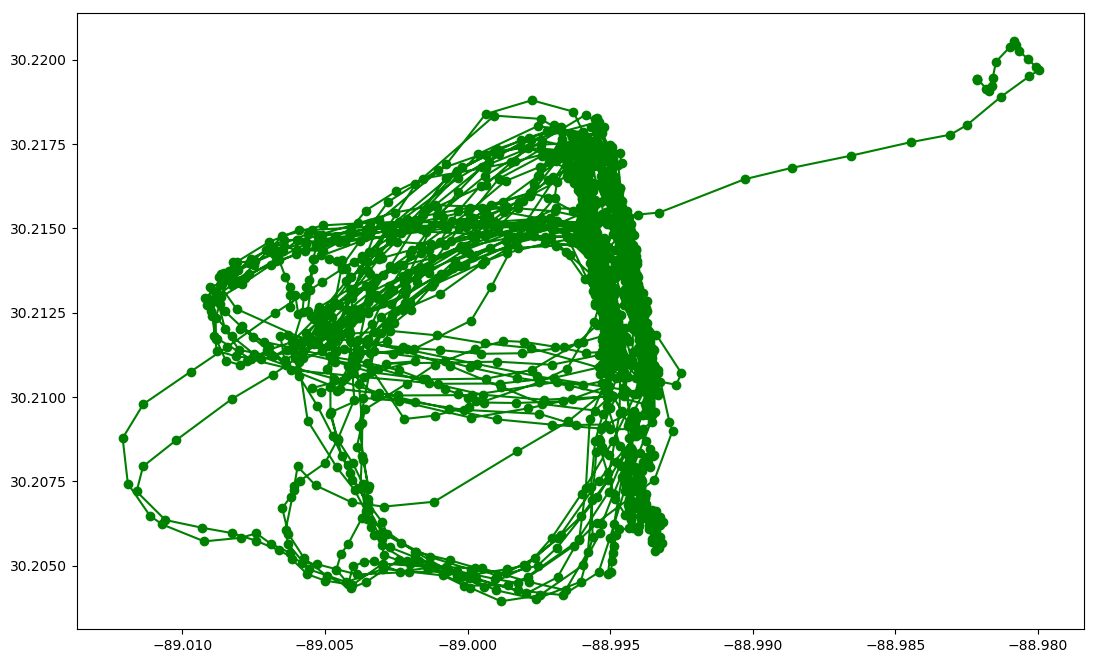

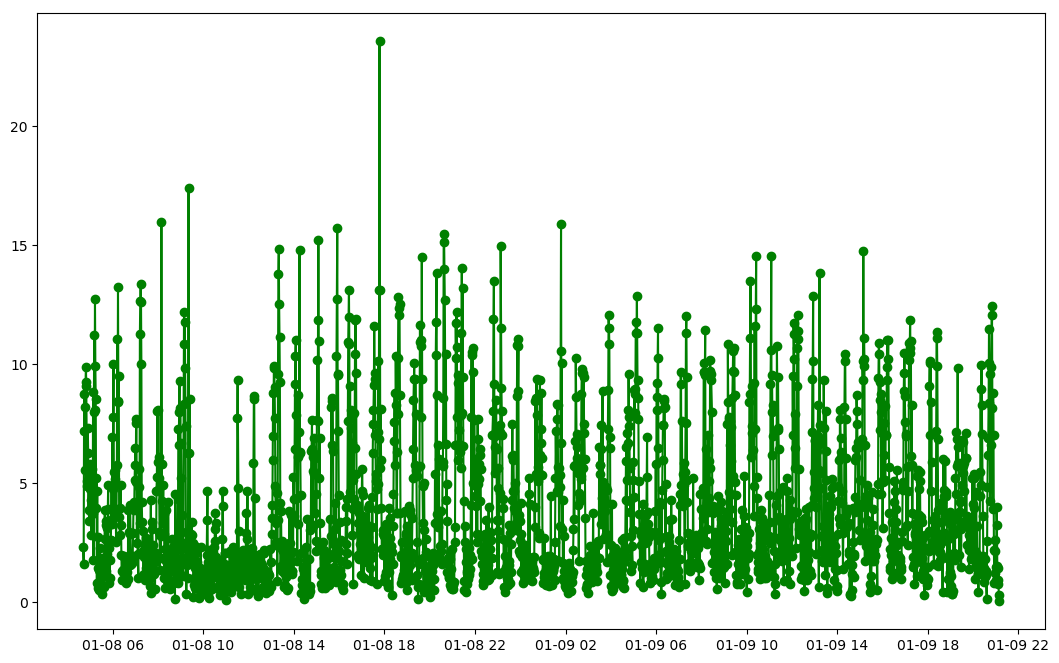

In [342]:
bbsubV = boundingboxData[boundingboxData.subVoyageIDs_subV == 19331] 
plt.plot(bbsubV.lon, bbsubV.lat, '-go')
plt.show()

plt.plot(bbsubV.Speed, '-go')
plt.show()

coordinates = list(zip(bbsubV.lat.tolist(), bbsubV.lon.tolist()))
m = folium.Map(location=[41.8240, -71.4128])
folium.PolyLine(coordinates, color = "Black").add_to(m)
m

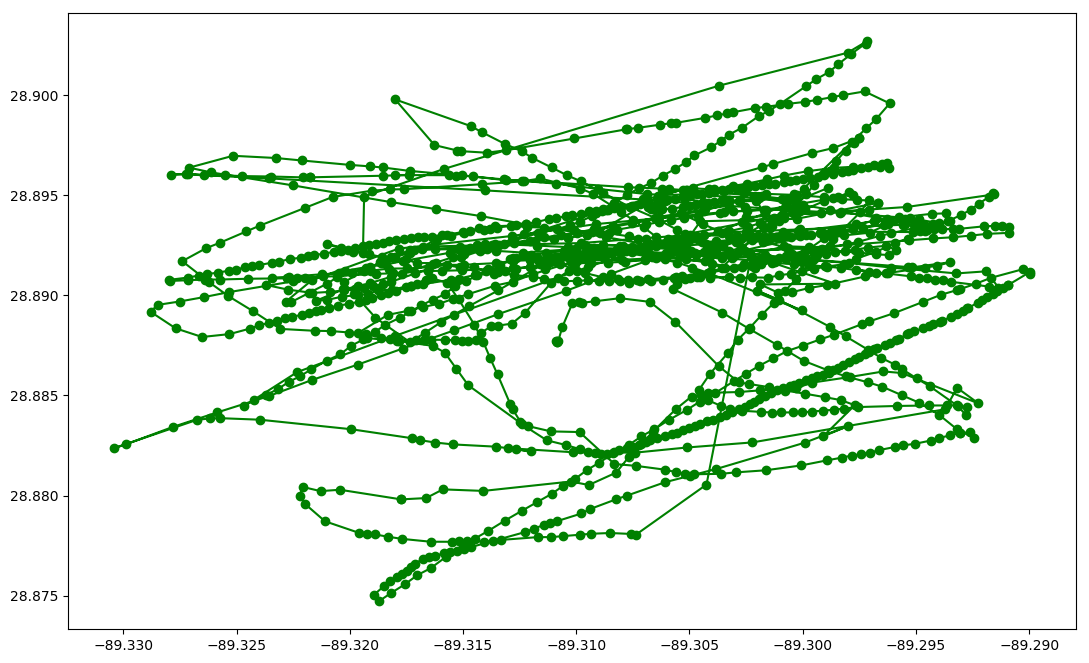

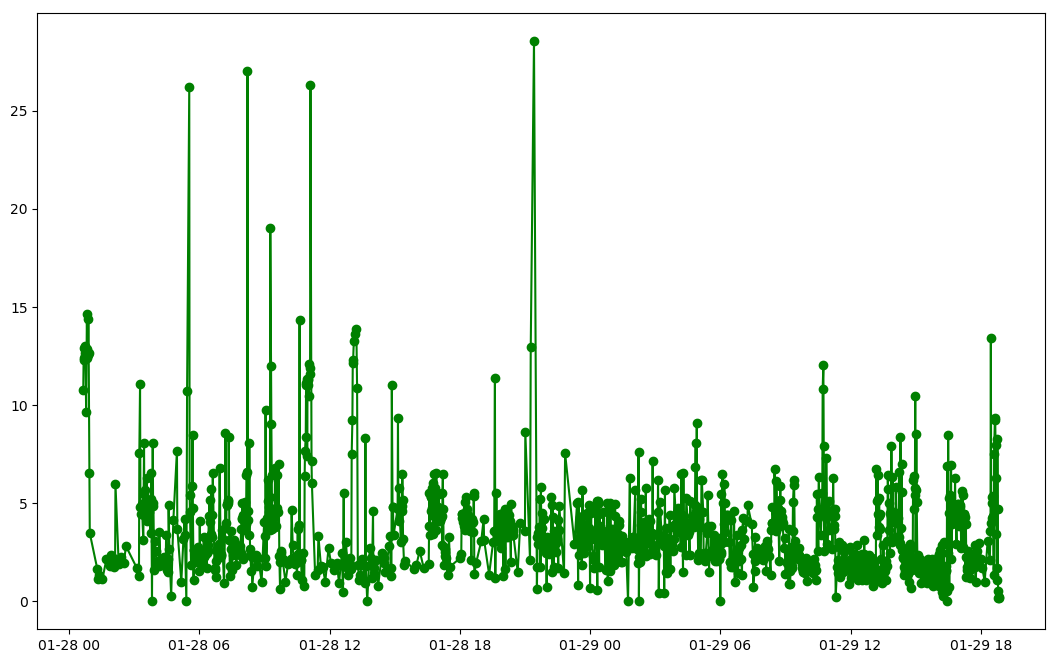

In [337]:
bbsubV = boundingboxData[boundingboxData.subVoyageIDs_subV == 58331] 
plt.plot(bbsubV.lon, bbsubV.lat, '-go')
plt.show()

plt.plot(bbsubV.Speed, '-go')
plt.show()

coordinates = list(zip(bbsubV.lat.tolist(), bbsubV.lon.tolist()))
m = folium.Map(location=[41.8240, -71.4128])
folium.PolyLine(coordinates, color = "Black").add_to(m)
m

In [162]:
dfdata= dfdata[~(dfdata.subVoyageIDs_subV.isin(boundingBoxSubV.subVoyageIDs_subV.unique()))]

In [163]:
len(dfdata.subVoyageIDs_subV.unique())

17021

In [164]:
41341 + 18272

59613

In [165]:
dataNoise = dfdata[dfdata['zScore_Noise'] == 'noise']

In [97]:
len(dataNoise.subVoyageIDs_subV.unique())

19634

In [37]:
# noiseVals= dataNoise[(dataNoise.Speed > 100) & (dataNoise.distance > 50) & (dataNoise.angle > 30)]
# uniqunoiseval = noiseVals.subVoyageIDs_subV.unique()
# noiseValData= dfdata[dfdata.subVoyageIDs_subV.isin(uniqunoiseval)]

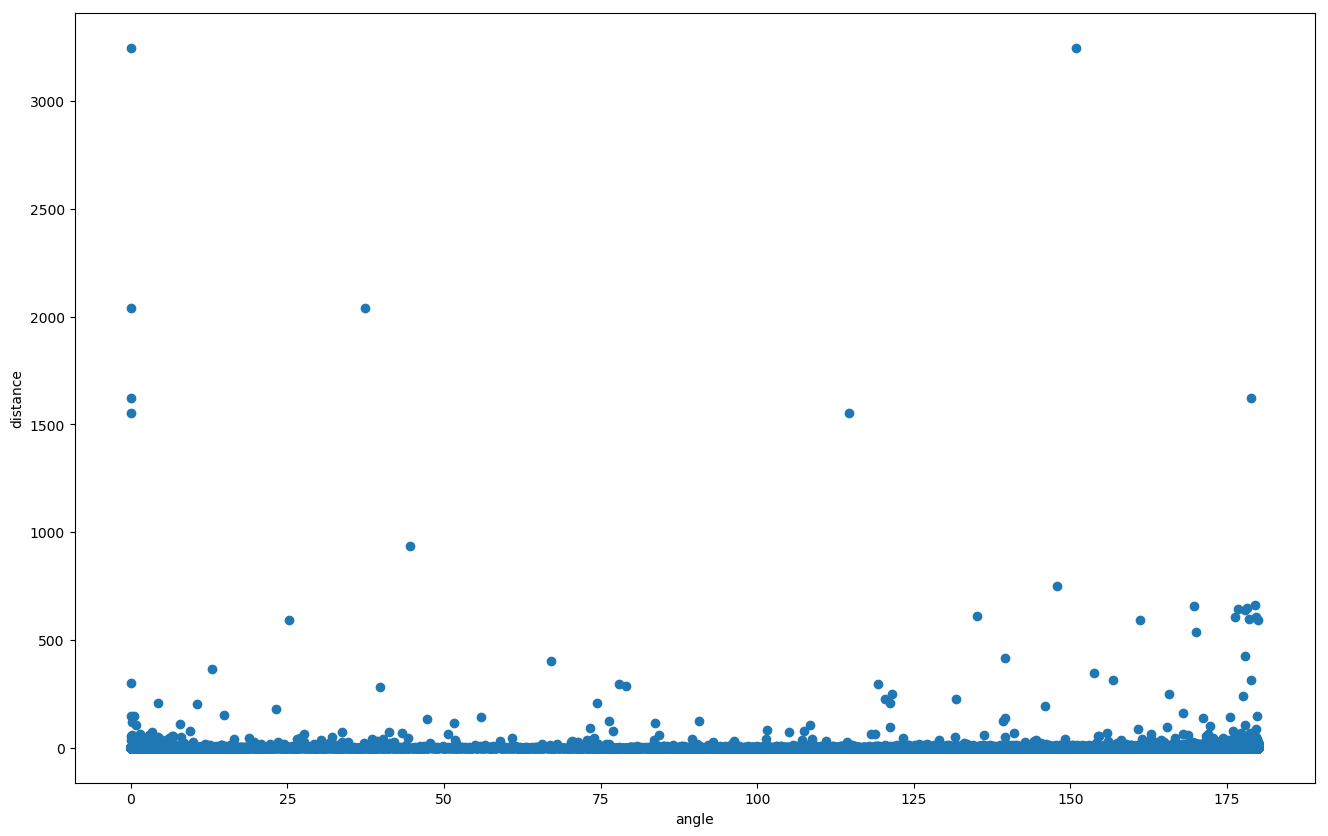

In [166]:
# Distance distributions

fig, ax = plt.subplots(figsize=(16,10))
ax.scatter(dataNoise.angle, dataNoise.distance)
ax.set_xlabel('angle')
ax.set_ylabel('distance')
plt.show()

In [167]:
# distanceNoise = dataNoise[dataNoise.distance.between(100, 200)]
distAngleNoise = dataNoise[dataNoise.angle.between(0 , 90)]
len(distAngleNoise)

6106

In [219]:
noise = distAngleNoise[(distAngleNoise.angle.between(0,10)) & (distAngleNoise.distance.between(500, distAngleNoise.distance.max()))].subVoyageIDs_subV.unique()
noise

array([36142, 50707, 52703, 61869])

In [221]:
SVcleaned = SV[~(SV.indexCol.isin(SVNoise.indexCol.unique()))]

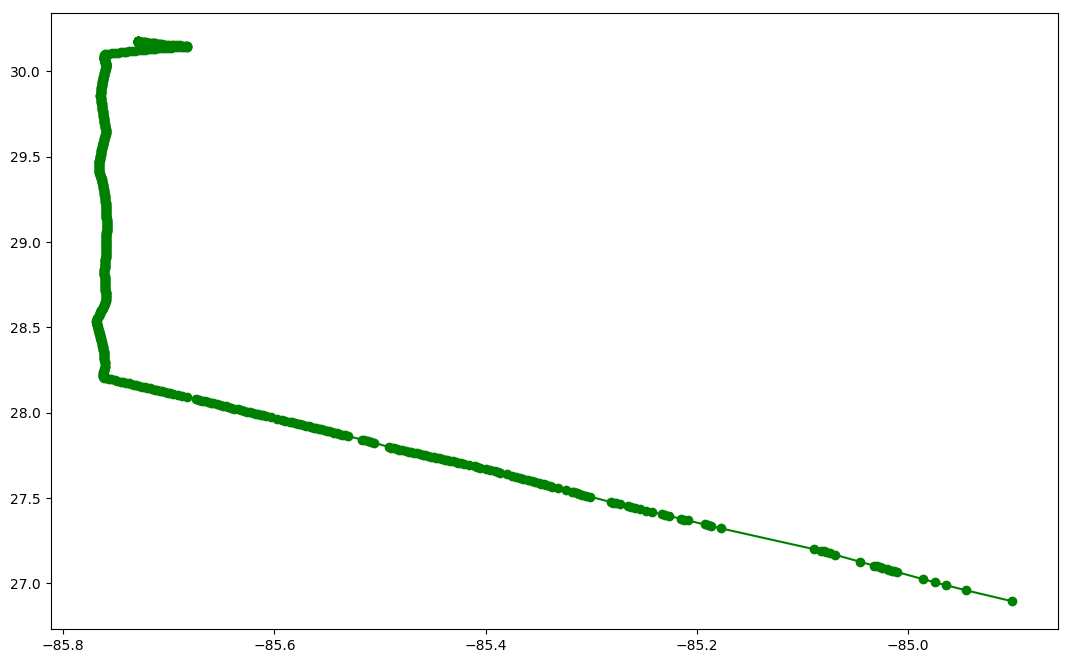

In [227]:
SV = dfdata[dfdata.subVoyageIDs_subV == 36142]
SVNoise = distAngleNoise[distAngleNoise.subVoyageIDs_subV == 36142]
# plt.plot(SV.lon, SV.lat, '-go')
plt.plot(SVcleaned.lon, SVcleaned.lat, '-go')
# plt.plot(SVNoise.lon, SVNoise.lat, 'ro')
plt.show()

coordinates = list(zip(SV.lat.tolist(), SV.lon.tolist()))
coordinatesclean = list(zip(SVcleaned.lat.tolist(), SVcleaned.lon.tolist()))
m = folium.Map(location=[41.8240, -71.4128])
folium.PolyLine(coordinates, color = "red").add_to(m)
folium.PolyLine(coordinatesclean, color = "blue").add_to(m)
m.save('example.html')

In [148]:
len(distAngleNoise.subVoyageIDs_subV.unique())

3093

In [100]:
LdistanceNoise = dataNoise[dataNoise.distance.between(10, dataNoise.distance.max())]
LdistAngleNoise = LdistanceNoise[LdistanceNoise.angle.between(0 , 180)]
len(LdistAngleNoise)

978

In [101]:
len(LdistAngleNoise.subVoyageIDs_subV.unique())

647

In [102]:
largeNoise =  dataNoise[(np.isnan(dataNoise.angle) == True) & (dataNoise.Speed > 100) & (dataNoise.distance > 10)]
len(largeNoise)

100

In [103]:
len(largeNoise.subVoyageIDs_subV.unique())

96

In [104]:
dfnoise = dfdata[((dfdata.Speed > 100) & (dfdata.distance > 100)) & (np.isnan(dfdata.angle) == True)]
len(dfnoise)

72

In [105]:
len(dfnoise.subVoyageIDs_subV.unique())

70

In [106]:
# # 35388, 18837
# subV = dfdata[dfdata.subVoyageIDs_subV == 19058]
# subV_noise= subV[subV.zScore_Noise == 'noise']
# # subVdist = subV.dist_ids.unique()

# plt.plot(subV.lon, subV.lat, '-go')
# plt.plot(subV_noise.lon, subV_noise.lat, 'ro')
# plt.show()


# plt.plot(subV.Speed, '-go')
# plt.plot(subV_noise.Speed, 'ro')
# plt.show()


# coordinates = list(zip(subV.lat.tolist(), subV.lon.tolist()))
# m = folium.Map(location=[41.8240, -71.4128])
# folium.PolyLine(coordinates, color = "Black").add_to(m)
# m

In [62]:
# #18861, 18874, 19006, 19032, 38636,  -- subVoyage on the map which is not breaking a part check why

# # 18925 49989
# data = dfdata[dfdata['subVoyageIDs_subV'] == 18853]
# # dtnoise = data[data.zScore_Noise == 'nose']
# display(data)

# plt.plot(data.lon, data.lat, '-go')
# plt.plot(dtnoise.lon, dtnoise.lat, 'ro')
# plt.show()

# coordinates = list(zip(data.lat.tolist(), data.lon.tolist()))
# m = folium.Map(location=[41.8240, -71.4128])
# folium.PolyLine(coordinates, color = "Black").add_to(m)
# m

In [63]:
# for idx, idp in enumerate(dataids):
#     display(idp)
#     tempdata = data[data['dist_ids'] == idp]
#     display(tempdata)
#     plt.plot(data.lon, data.lat, '-go', alpha= 0.4)
#     plt.plot(tempdata.lon, tempdata.lat, '-yo')
#     plt.show()
    

In [107]:
rawData= dfdata[(dfdata.subVoyageIDs_subV.isin(distAngleNoise.subVoyageIDs_subV.unique())) | (dfdata.subVoyageIDs_subV.isin(LdistAngleNoise.subVoyageIDs_subV.unique())) | (dfdata.subVoyageIDs_subV.isin(largeNoise.subVoyageIDs_subV.unique())) | (dfdata.subVoyageIDs_subV.isin(dfnoise.subVoyageIDs_subV.unique())) ] 

In [108]:
display(len(rawData))
display(len(rawData.subVoyageIDs_subV.unique()))

1301678

3543

In [109]:
totalNoise = rawData[(rawData.indexCol.isin(distAngleNoise.indexCol)) | (rawData.indexCol.isin(LdistAngleNoise.indexCol)) | (rawData.indexCol.isin(largeNoise.indexCol)) | (rawData.indexCol.isin(dfnoise.indexCol))]

In [110]:
len(totalNoise)

7731

In [111]:
cleanedData= rawData[~(rawData.indexCol.isin(totalNoise.indexCol))]

In [112]:
display(len(cleanedData))
display(len(cleanedData.subVoyageIDs_subV.unique()))

1293947

3543

# Calculating the new distance after removing the noise points from the data

In [70]:
df_cleaned= dfdata[dfdata.indexCol.isin(cleanedData.indexCol)]

In [71]:
del df_cleaned['lat_1']
del df_cleaned['lat1']
del df_cleaned['lon_1']
del df_cleaned['lon1']
del df_cleaned['totalHours']

In [72]:
# Calculatying the new distance and the new speed after remocing the actual noise points

df_cleaned['ChecksubVID']=df_cleaned.subVoyageIDs_subV !=  df_cleaned.subVoyageIDs_subV.shift(1)
df_cleaned['latrad']= np.where(df_cleaned['ChecksubVID'] != True, df_cleaned.lat.shift(1).apply(radians), np.nan)
df_cleaned['lonrad']= np.where(df_cleaned['ChecksubVID'] != True, df_cleaned.lon.shift(1).apply(radians), np.nan)
lat1 = df_cleaned['lat'].apply(radians)
lon1 = df_cleaned['lon'].apply(radians)
dlon = df_cleaned['lonrad'] - lon1 
dlat = df_cleaned['latrad'] - lat1
harvesineDist = (dlat/2).apply(sin)**2 + lat1.apply(cos) * df_cleaned['latrad'].apply(cos) * (dlon/2).apply(sin)**2
c = 2* np.arcsin(harvesineDist.apply(sqrt))
dist = 6367 * c
df_cleaned['newdist'] = dist

# totalHours = df_cleaned.DateTime.diff().dt.seconds/3600
df_cleaned['totalHours']= np.where(df_cleaned['ChecksubVID'] != True, df_cleaned.DateTime.diff().dt.seconds/3600, np.nan)
df_cleaned['newspeed']= df_cleaned['newdist'] / df_cleaned['totalHours']

In [73]:
del df_cleaned['ChecksubVID']
del df_cleaned['latrad']
del df_cleaned['lonrad']
del df_cleaned['totalHours']

# Removing data on Speed and Distance

In [74]:
# breaking trajectories based on new distance and the new speed, hwere it seems having the large gaps of speed and distance
# df_cleaned['dist_groups']= df_cleaned.groupby('subVoyageIDs_subV').apply(lambda x: ((x.newdist > 10) & (x.newspeed > 50))).values
# df_cleaned['dist_ids']=  (df_cleaned.groupby('subVoyageIDs_subV').apply(lambda x:x.dist_groups.shift(1)) != df_cleaned.groupby('subVoyageIDs_subV').apply(lambda x:x.dist_groups) | (df_cleaned.groupby('subVoyageIDs_subV').apply(lambda x: ((x.newdist > 10) & (x.newspeed > 100) )).values)).astype(int).cumsum().values

df_cleaned['dist_groups']= df_cleaned.groupby('subVoyageIDs_subV').apply(lambda x: ((x.newdist > 10) & (x.newspeed > 50))).values
df_cleaned['dist_ids']=  ((df_cleaned.groupby('subVoyageIDs_subV').apply(lambda x:x.dist_groups.shift(1)) != (df_cleaned.groupby('subVoyageIDs_subV').apply(lambda x:x.dist_groups))) | (df_cleaned.groupby('subVoyageIDs_subV').apply(lambda x: ((x.newdist > 10) & (x.newspeed > 100) )).values)).astype(int).cumsum().values

In [75]:
totalPoints= df_cleaned.groupby('dist_ids').agg({'Speed':'count'}).reset_index().rename(columns={'Speed':'totalPoints'})
totalPoints= totalPoints[totalPoints.totalPoints > 10]
cleanedData= df_cleaned[df_cleaned.dist_ids.isin(totalPoints.dist_ids.unique())]

In [60]:
# creating the geometery from thr rawData
uniqueRawIDs = rawData.subVoyageIDs_subV.unique()

geos = []
for idx, number in  enumerate(uniqueRawIDs):
    subV = rawData[rawData['subVoyageIDs_subV'] == number]
    geoLDISTData =  [[lon,lat] for lon,lat in zip(subV.lon ,subV.lat)]
    poly = {
            "type": "Feature",
            "properties":{"sample": len(subV.subVoyageIDs_subV), 'id': float(subV.subVoyageIDs_subV.unique())},            
            "geometry" : {
            "type" : "LineString",
            "coordinates" : geoLDISTData,
        }
    }
    geos.append(poly)

geometry = FeatureCollection(geos)

In [59]:
json.dump(geometry, open("Zone16_2011_01_rawGeometery.geojson","w"))

In [60]:
# # Creating geometery from the clean Data
uniqueCleanedIDs = cleanedData.dist_ids.unique()
geos = []
for idx, number in  enumerate(uniqueCleanedIDs):
    subV = cleanedData[cleanedData['dist_ids'] == number]
    geoClData =  [[lon,lat] for lon,lat in zip(subV.lon ,subV.lat)]
    poly = {
            "type": "Feature",
            "properties":{"sample": len(subV.dist_ids), 'id': float(subV.dist_ids.unique())},            
            "geometry" : {
            "type" : "LineString",
            "coordinates" : geoClData,
        }
    }
    geos.append(poly)

geometry = FeatureCollection(geos)     

In [61]:
json.dump(geometry, open("Zone16_2011_01_cleanedGeometery.geojson","w"))

In [351]:
dfdata.subVoyageIDs_subV.unique()

array([   73,    83,    87, ..., 61295, 61296, 61298])

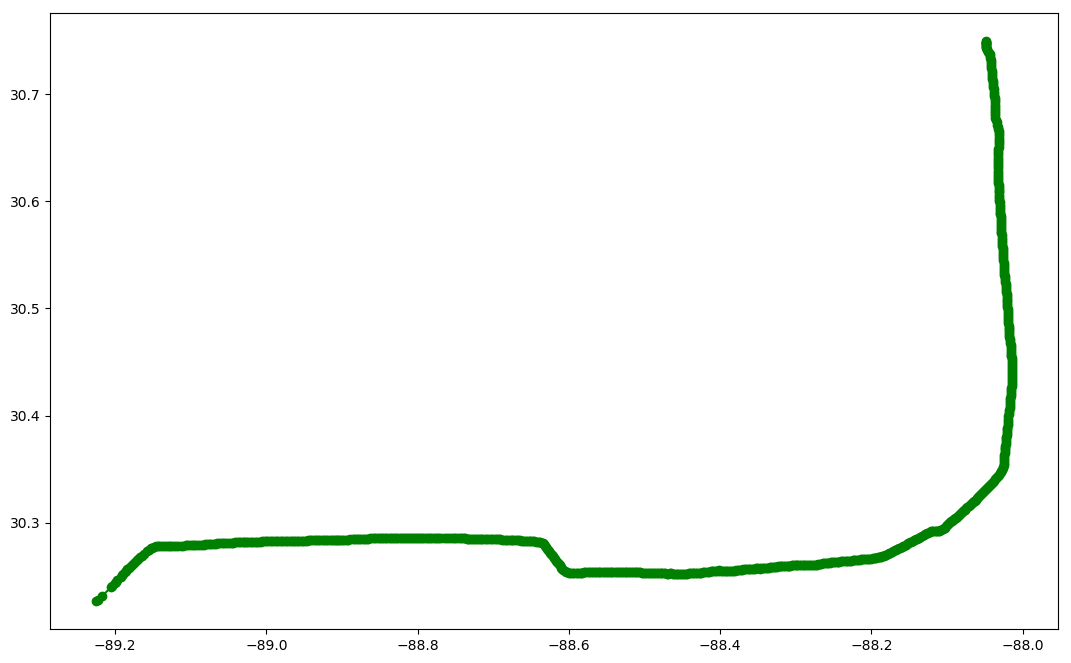

In [356]:
subV= dfdata[dfdata['subVoyageIDs_subV'] == 87]
subVCleaned= cleanedData[cleanedData['subVoyageIDs_subV'] == 87]

# # display(subV)
# plt.plot(subV.Speed, '-go')
# plt.plot(subVCleaned.Speed, '-ro')
# plt.show()

plt.plot(subV.lon, subV.lat, '-go')
plt.plot(subVCleaned.lon, subVCleaned.lat , '-ro')
plt.savefig('VoyageDistributions/trajectoryExampleimage.png')
plt.show()


coordinates = list(zip(subV.lat.tolist(), subV.lon.tolist()))
m = folium.Map(location=[41.8240, -71.4128])
folium.PolyLine(coordinates, color = "Black").add_to(m)
m.save('VoyageDistributions/trajectoryExample.html')

In [72]:
boundingUniqueIDs

array([     2,      4,      6, ..., 128135, 128141, 128145])

In [62]:
# # Creating geometery from the clean Data

geos = []
for idx, number in  enumerate(bbUnique):
    subV = boundingboxData[boundingboxData['subVoyageIDs_subV'] == number]
    geoBoundingData =  [[lon,lat] for lon,lat in zip(subV.lon ,subV.lat)]
    poly = {
            "type": "Feature",
            "properties":{"sample": len(subV.subVoyageIDs_subV), 'id ': float(subV.subVoyageIDs_subV.unique())},            
            "geometry" : {
            "type" : "LineString",
            "coordinates" : geoBoundingData,
        }
    }
    geos.append(poly)

geometry = FeatureCollection(geos)     

In [63]:
json.dump(geometry, open("Zone16_2011_01_boundingBoxGeometery.geojson","w"))

In [64]:
dataIDs = dfdata.subVoyageIDs_subV.unique()

In [65]:
# Creating geometery from the Raw Data

geos = []
for idx, number in  enumerate(dataIDs):
    subV = dfdata[dfdata['subVoyageIDs_subV'] == number]
    geoDfData =  [[lon,lat] for lon,lat in zip(subV.lon ,subV.lat)]
    poly = {
            "type": "Feature",
            "properties":{"sample": len(subV.subVoyageIDs_subV), 'id': float(subV.subVoyageIDs_subV.unique())},            
            "geometry" : {
            "type" : "LineString",
            "coordinates" : geoDfData,
        }
    }
    geos.append(poly)

geometry = FeatureCollection(geos)     
# geometry



In [66]:
json.dump(geometry, open("Zone16_2011_01_rawGeometery_dfdata.geojson","w"))

In [211]:
# map data to show rawdata, then noise data and circles to point out the noise points.

rawData = os.path.join('jsonfiles', 'Zone16_01_MiddleNoise_rawGeometery.geojson')
CleanedData = os.path.join('jsonfiles', 'Zone16_01_MiddleNoise_cleanedgeometery.geojson') 

def style_function(feature):
    return {
        'fillOpacity': 0.2,
        'weight': 2,
        'color': 'yellow'
    }

def style_functionA(feature):
    return {
        'fillOpacity': 0.2,
        'weight': 2,
        'color': 'red'
}

m = folium.Map(
    location=[-59.1759, -11.6016], tiles='stamenterrain', zoom_start=5
)

folium.TileLayer('openstreetmap').add_to(m)
folium.TileLayer('StamenToner').add_to(m)
folium.TileLayer('stamenterrain').add_to(m)
folium.TileLayer('Mapbox Control Room').add_to(m)

folium.GeoJson(
    rawData,
    name='rawData',
    style_function= style_functionA
).add_to(m)

folium.GeoJson(
    CleanedData,
    name='Cleaned data',
    style_function= style_function
).add_to(m)


# datacord = list(zip(noiseData_angle.lat, noiseData_angle.lon))
# for datacordlatlon in datacord:
#     folium.CircleMarker(datacordlatlon, radius=10,  color='green').add_to(m)


folium.LayerControl().add_to(m)
m.save('geometry_MidNoise_zone16.html')


# mEETING nOTES

- check the segments and break it into parts if those are less than 10 segments or less then 8 segments discard them and make them a clearly a new part of the trajectory, 

- try to work with the mapbox gl or with the kapler gl or check out the vector tile library in case of the performance measure, 

- make some color or some thing to make it visible the mid part of the noise to make it more better interm of the vizualization or something.


- so to get the trajectories which are having the large distance, remove those points and then calculate the distance speed and time, just after that take out the data which has obvious the long distance and because of the long speed take out those data break the trajectory into parts and make sure it gives the right results, and then plot then on the map and see what are the good results.




In [64]:
print('Data Statistics -- Zone16_2011_01')
print('                     ')
print('Total Vessels:', len(df_CenteredWin.MMSI.unique()))
print('Trajectories:', len(df_CenteredWin.VoyageID.unique()))
print('subTrajectories:', len(df_CenteredWin.subVoyageIDs.unique()))

print('                     ')
print('Breaking into time and excluding small points the subTrajectories becomes')
print('Total Vessels:', len(df_data.MMSI.unique()))
print('Trajectories:', len(df_data.VoyageID.unique()))
print('Total subTrajectories:', len(df_data.subVoyageIDs.unique()))
print('subTrajectories Broke on Time:', len(df_data.subVoyageIDs_subV.unique()))

print('                     ')
print('Applied Z-Score to find out the noisy subTrajectories')
print('Noise Points:',len(dataNoise))
print('Total Trajectories:',len(dataNoise.VoyageID.unique()))
print('subTrajectories with Noisepoints:', len(dataNoise.subVoyageIDs_subV.unique()))


print('                     ')
print('Excluded short subTrajectories though the bounding box technique')
print('short Trajectories:', len(boundingBoxSubV.subVoyageIDs_subV.unique()))

print('                     ')
print('Remaining subTrajectories after Excluding through Bounding Box')
print('Remaining subTrajectories:',len(dfdata.subVoyageIDs_subV.unique()))


print('                     ')
print('Large Noise subTrajectories')
print('Large Noise Points:',len(LdistAngleNoise))
print('Total SubTrajectories:',len(LdistAngleNoise.subVoyageIDs_subV.unique()))

print('                     ')
print('Short Noise subTrajectories')
print('Short Noise Points:',len(distAngleNoise))
print('Total SubTrajectories:',len(distAngleNoise.subVoyageIDs_subV.unique()))

print('                     ')
print('Raw Trajectories')
print('Total Raw Trajectories:',len(rawData.VoyageID.unique()))
print('Total Raw SubTrajectories :',len(rawData.subVoyageIDs_subV.unique()))


print('                     ')
print('Clean Trajectories')
print('Total Cleaned Trajectories:',len(cleanedData.VoyageID.unique()))
print('Total Cleaned SubTrajectories :',len(cleanedData.subVoyageIDs_subV.unique()))

Data Statistics -- Zone16_2011_01
                     
Total Vessels: 2559
Trajectories: 4717
subTrajectories: 52590
                     
Breaking into time and excluding small points the subTrajectories becomes
Total Vessels: 2559
Trajectories: 4717
Total subTrajectories: 52590
subTrajectories Broke on Time: 56310
                     
Applied Z-Score to find out the noisy subTrajectories
Noise Points: 627196
Total Trajectories: 3986
subTrajectories with Noisepoints: 15279
                     
Excluded short subTrajectories though the bounding box technique
short Trajectories: 37668
                     
Remaining subTrajectories after Excluding through Bounding Box
Remaining subTrajectories: 18642
                     
Large Noise subTrajectories
Large Noise Points: 59
Total SubTrajectories: 44
                     
Short Noise subTrajectories
Short Noise Points: 5129
Total SubTrajectories: 2782
                     
Raw Trajectories
Total Raw Trajectories: 1809
Total Raw SubTraje

In [76]:
d = {'Vessels': [len(df_CenteredWin.MMSI.unique())], 'Trajectories': len(df_CenteredWin.VoyageID.unique()), 'subTrajectories': len(df_CenteredWin.subVoyageIDs.unique()), 'subTrajectories Broke on Time': len(df_data.subVoyageIDs_subV.unique()), 'Short SubTrajectories or bad Data': len(boundingBoxSubV.subVoyageIDs_subV.unique()), 
                'Remaining Data after': len(dfdata.subVoyageIDs_subV.unique()), 'Raw Trajectories': len(rawData.subVoyageIDs_subV.unique()), 
                'Cleaned Trajectories': len(cleanedData.subVoyageIDs_subV.unique()), 'Noise Points' : len(totalNoise)}
staticsData = pd.DataFrame(data=d)
display(staticsData)
staticsDataTable= staticsData.stack().reset_index(name = "TotalData").rename(columns={'level_1': 'label'})
del staticsDataTable['level_0']
print(staticsDataTable)


,Cleaned Trajectories,Noise Points,Raw Trajectories,Remaining Data after,Short SubTrajectories or bad Data,Trajectories,Vessels,subTrajectories,subTrajectories Broke on Time
0,3512,7731,3543,21340,26000,4744,2572,40342,47340


                               label  TotalData
0               Cleaned Trajectories       3512
1                       Noise Points       7731
2                   Raw Trajectories       3543
3               Remaining Data after      21340
4  Short SubTrajectories or bad Data      26000
5                       Trajectories       4744
6                            Vessels       2572
7                    subTrajectories      40342
8      subTrajectories Broke on Time      47340


In [ ]:
ax = staticsDataTable.plot.bar(x='label', y='TotalData')
ax.tick_params(axis='x', labelrotation=90)
plt.show()

In [89]:
data= df_data[~(df_data.subVoyageIDs_subV.isin(rawData.subVoyageIDs_subV.unique()))]
frames = [data, cleanedData] 
df_ = pd.concat(frames)
display(len(df_))
display(len(df_.subVoyageIDs_subV.unique()))

del frames
del data
del df_['DateTime']

table = pa.Table.from_pandas(df_)

5582269

59577

In [90]:
rm -r '/bigdata0/rshankar/Zone16_2011/01/df_Zone16_2011_01.parquet'

In [91]:
pq.write_table(table, '/bigdata0/rshankar/Zone16_2011/01/df_Zone16_2011_01.parquet')

In [309]:
angleNoise =  distAngleNoise[(distAngleNoise.angle.between(0,20))&(distAngleNoise.distance.between(5,10))]

In [310]:
angleNoise

,DateTime,MMSI,Speed,VoyageID,distance,indexCol,lat,lon,subVoyageIDs,subVoyageIDs_subV,totalHours,centeredMean,centeredSTD,centeredZScore,zScore_Noise,lat1,lat_1,lon1,lon_1,angle
DateTime,,,,,,,,,,,,,,,,,,,,
2011-01-27 16:47:59,2011-01-27 16:47:59,366920969,430.541933,73,7.056104,14981287,39.100437,-84.688957,929477,3860,0.016389,51.986148,179.711789,2.106460,noise,39.144300,39.144283,-84.748137,-84.743707,2.144067
2011-01-29 01:59:00,2011-01-29 01:59:00,367204195,58.899152,91,5.889915,15809668,28.753517,-89.417735,1135319,4582,0.100000,18.466562,19.738591,2.048403,noise,28.805973,28.775517,-89.426397,-89.421115,0.642153
2011-01-19 05:57:00,2011-01-19 05:57:00,367291017,307.935658,170,5.217799,10221210,28.847350,-89.431138,2222955,10006,0.016944,32.262134,88.724754,3.107064,noise,28.894253,28.852012,-89.428633,-89.430405,5.878234
2011-01-01 15:06:00,2011-01-01 15:06:00,367520730,422.700753,306,7.162429,334332,29.525157,-89.157795,4543619,18914,0.016944,36.007784,206.754975,1.870296,noise,29.489603,29.410008,-89.096022,-88.982552,3.385229
2011-01-02 23:06:59,2011-01-02 23:06:59,367520730,535.901749,306,8.782834,1065959,28.612043,-89.064713,4544737,18930,0.016389,98.733669,433.587211,1.008259,noise,28.688993,29.409808,-89.044160,-88.982632,9.079938
2011-01-03 06:36:59,2011-01-03 06:36:59,367520730,375.243155,306,6.149818,1248861,29.552183,-89.694002,4544948,18933,0.016389,68.082990,147.512398,2.082267,noise,29.545755,29.409907,-89.630817,-88.982797,5.503757
2011-01-05 00:53:59,2011-01-05 00:53:59,367520730,347.622933,306,5.697154,2287096,29.305218,-89.006588,4546298,18958,0.016389,16.904733,64.875205,5.097760,noise,29.352248,29.409898,-88.983177,-88.982650,13.582803
2011-01-08 08:26:59,2011-01-08 08:26:59,367520730,557.508294,306,9.136941,4139079,29.436790,-89.000418,4548775,19003,0.016389,95.923592,311.617477,1.481254,noise,29.439237,29.436663,-89.094788,-89.007873,2.461309
2011-01-09 17:18:00,2011-01-09 17:18:00,367520730,366.805424,306,6.215314,4887170,29.413287,-89.006807,4549811,19018,0.016944,29.442091,106.203970,3.176560,noise,29.409258,29.413117,-88.942768,-89.006323,15.753291


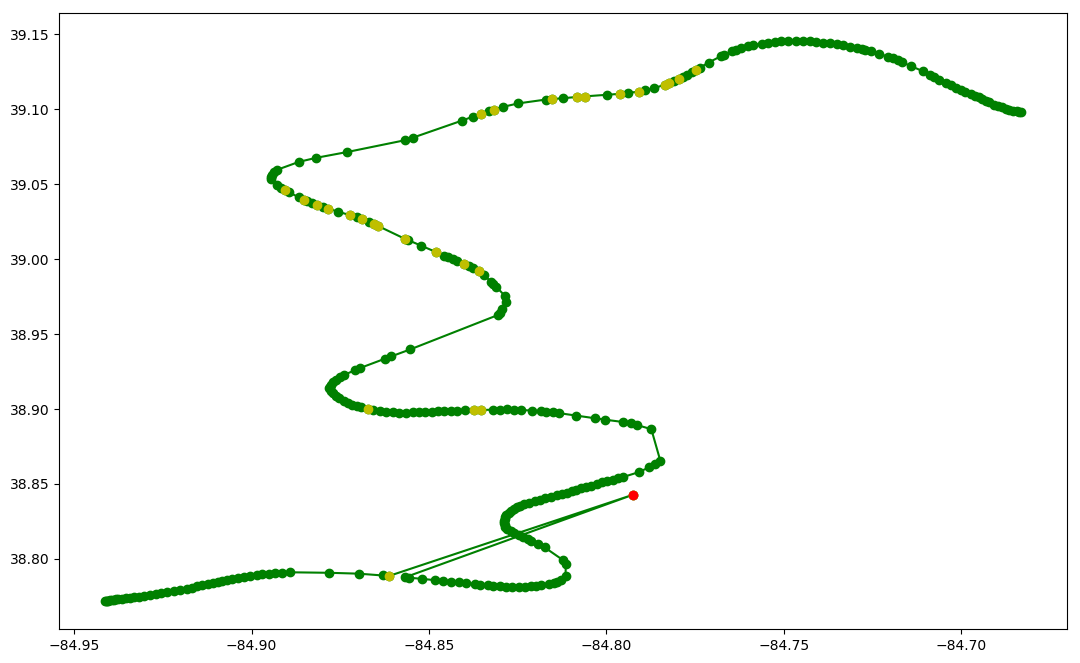

In [315]:
sub = dfdata[dfdata['subVoyageIDs_subV'] == 28173]
noise = sub[sub['zScore_Noise'] == 'noise']
# sub_noise = distAngleNoise[distAngleNoise['subVoyageIDs_subV'] == 8694]
sub_noise_angle = angleNoise[angleNoise['subVoyageIDs_subV'] == 28173]

plt.plot(sub.lon, sub.lat, '-go')
plt.plot(noise.lon, noise.lat, 'yo')
plt.plot(sub_noise_angle.lon, sub_noise_angle.lat, 'ro')
plt.show()

In [318]:
cleaned = sub[~(sub.indexCol.isin(sub_noise_angle.indexCol))]

In [319]:
coordinates = list(zip(sub.lat.tolist(), sub.lon.tolist()))
coordinatesCleaned = list(zip(cleaned.lat.tolist(), cleaned.lon.tolist()))
m = folium.Map(location=[41.8240, -71.4128])
folium.PolyLine(coordinates, color = "red").add_to(m)
folium.PolyLine(coordinatesCleaned, color = "blue").add_to(m)
m.save('anglewithspeedzscore.html')

In [92]:
# df_ = dfdata[~(dfdata.indexCol.isin(totalNoise.indexCol))]
# dataIndex = df_[~(df_.VoyageID.isin(cleanedData.VoyageID.unique()))]
# frames = [dataIndex, cleanedData]
# dfNewData = pd.concat(frames)
# df_ = dfNewData[dfNewData.duplicated() == False]

# del dfNewData
# del dataIndex
# del frames
# del df_['DateTime']
# table = pa.Table.from_pandas(df_)

In [62]:
# df_ = dfdata[~(dfdata.indexCol.isin(totalNoise.indexCol))]
# dataIndex = df_[df_.indexCol.isin(cleanedData.indexCol)]
# frames = [df_, dataIndex]
# dfNewData = pd.concat(frames)
# df_ = dfNewData[dfNewData.duplicated() == False]

# del dfNewData
# del dataIndex
# del frames
# del df_['DateTime']
# table = pa.Table.from_pandas(df_)

In [67]:
# rm -r '/bigdata0/rshankar/Zone16_2011/01/df_Zone16_2011_01.parquet'

In [66]:
# pq.write_table(table, '/bigdata0/rshankar/Zone16_2011/01/df_Zone16_2011_01.parquet')

## meeTing noTes
- make the trends of the different zones and different months with seprate years to analyze the difference between the data

- load the cleaned data of first month into the memory and then the second month data and keep the trajectory data which is going to the second month but exclude the other ones and then see how many trajectories are connected together

- try to load the latest zone data and check if these noise are decreasing or still having this much number of noise points in it 